# Non Homogeneous Hidden Markov Model

## Library Loading and Configuration

In [24]:
import os
os.environ["R_HOME"] = r"C:\Program Files\R\R-4.5.0"  # Change this path according to your R installation.

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import IntVector

# Enable conversion between pandas and R
pandas2ri.activate()

# Load the R base package
base = importr('base')
# Load the package depmixS4
depmixS4 = importr("depmixS4")
# Set the seed in R for reproducibility
r('set.seed(2030)')
# Set seed in Python for reproducibility
np.random.seed(2030)

## Data loading and preparation:

In [25]:
covid_data = pd.read_excel('../data/covid_data.xlsx')

In [26]:
covid_data.columns

Index(['IM_interno', 'IM_externo', 'inc_pc_comuna', 'TasaCasosAcumulados',
       'Personas_hogar_promedio', 'inmigrantes', 'total_hog_hacinados',
       'indic_precariedad_vivienda', 'Comuna', 'fecha', 'dias', 'por_educ_sup',
       'porc_postgrado', 'IPS_2020', 'Prioridad_2020', 'CODIGO', 'year',
       'month', 'paso', 'paso_etiqueta', 'Fecha inicio cuarentena',
       'Fecha término cuarentena', 'Casos_Diarios_Brutos',
       'Casos_Diarios_Brutos_MM7'],
      dtype='object')

In [27]:
covid_data.rename(columns={'IM_interno': 'Internal_Mobility_Index',
                           'IM_externo': 'External_Mobility_Index',
                           'inc_pc_comuna': 'Per_Capita_Income',
                           'TasaCasosAcumulados': 'Cumulative_Cases_Rate',
                           'Personas_hogar_promedio': 'Average_Household_Persons',
                           'inmigrantes': 'Inmigrants',
                           'total_hog_hacinados': 'Total_Households_Housed',
                           'indic_precariedad_vivienda': 'Housing_Precariousness_Index',
                           'Comuna': 'Commune',
                           'fecha': 'Date',
                           'dias': 'Days',
                           'por_educ_sup': 'Higher_Education_Percentage',
                           'porc_postgrado': 'Postgraduade_Percentage',
                           'IPS_2020': 'Social_Priority_Index_2020',
                           'Prioridad_2020': 'Priority_2020',
                           'CODIGO':'Code',
                           'year': 'Year',
                           'month': 'Month',
                           'paso': 'Step',
                           'paso_etiqueta': 'Step_Label',
                           'Fecha inicio cuarentena': 'Quarantine_Start_Date',
                           'Fecha término cuarentena': 'Quarantine_End_Date',
                           'Casos_Diarios_Brutos': 'Gross_Daily_Cases',
                           'Casos_Diarios_Brutos_MM7': 'Gross_Daily_Cases_Mobile_Average_7_Days'}, inplace=True)

In [28]:
covid_data.columns

Index(['Internal_Mobility_Index', 'External_Mobility_Index',
       'Per_Capita_Income', 'Cumulative_Cases_Rate',
       'Average_Household_Persons', 'Inmigrants', 'Total_Households_Housed',
       'Housing_Precariousness_Index', 'Commune', 'Date', 'Days',
       'Higher_Education_Percentage', 'Postgraduade_Percentage',
       'Social_Priority_Index_2020', 'Priority_2020', 'Code', 'Year', 'Month',
       'Step', 'Step_Label', 'Quarantine_Start_Date', 'Quarantine_End_Date',
       'Gross_Daily_Cases', 'Gross_Daily_Cases_Mobile_Average_7_Days'],
      dtype='object')

### Dictionary of variables:
- **'Internal_Mobility_Index'**: Index of internal mobility of the communes.
- **'External_Mobility_Index'**: Index of external mobility of the communes.
- **'Per_Capita_Income'**: Per capita income of the communes.
- **'Cumulative_Cases_Rate'**: Cumulative case rate per 100,000 population.
- **'Average_Household_Persons'**: Average number of persons per household in the communes.
- **'Inmigrants'**: Percentage of immigrants in the communes.
- **'Total_Households_Housed'**: Percentage of overcrowded households in the communes.
- **'Housing_Precariousness_Index'**: Indicator of housing precariousness in the municipalities.
- **'Commune'**: Name of the commune.
- **'Date'**: Date of observation.
- **'Days'**: Number of days since the beginning of the records.
- **'Higher_Education_Percentage'**: Percentage of people with higher education in the communes.
- **'Postgraduade_Percentage'**: Percentage of people with a postgraduate degree in the communes.
- **'Social_Priority_Index_2020'**: Social Priority Index 2020 of the communes.
- **'Priority_2020'**: 2020 Social Priority of the communes.
- **'Code'**: Code of the commune.
- **'Year'**: Year of observation.
- **'Month'**: Month of observation.
- **'Step'**: Commune Step by Step Plan.
- **'Step_Label'**: Label of the commune's passage in the Step by Step Plan.
- **'Quarantine_Start_Date'**: Quarantine start date.
- **'Quarantine_End_Date'**: Date of end of quarantine.
- **'Gross_Daily_Cases'**: Number of gross daily cases.
- **'Gross_Daily_Cases_Mobile_Average_7_Days'**: Number of gross daily cases with 7-day moving average.

In [29]:
# Remove rows with null values in the relevant columns:
covid_data = covid_data.dropna(subset=['Gross_Daily_Cases', 'Gross_Daily_Cases_Mobile_Average_7_Days', 'Date'])
# Reset index and add row_id for merge:
covid_data = covid_data.reset_index(drop=True)
covid_data['row_id'] = covid_data.index  # for subsequent merge

## Exploratory Data Analysis (EDA):

### Gross Daily Cases with 7-day moving average:

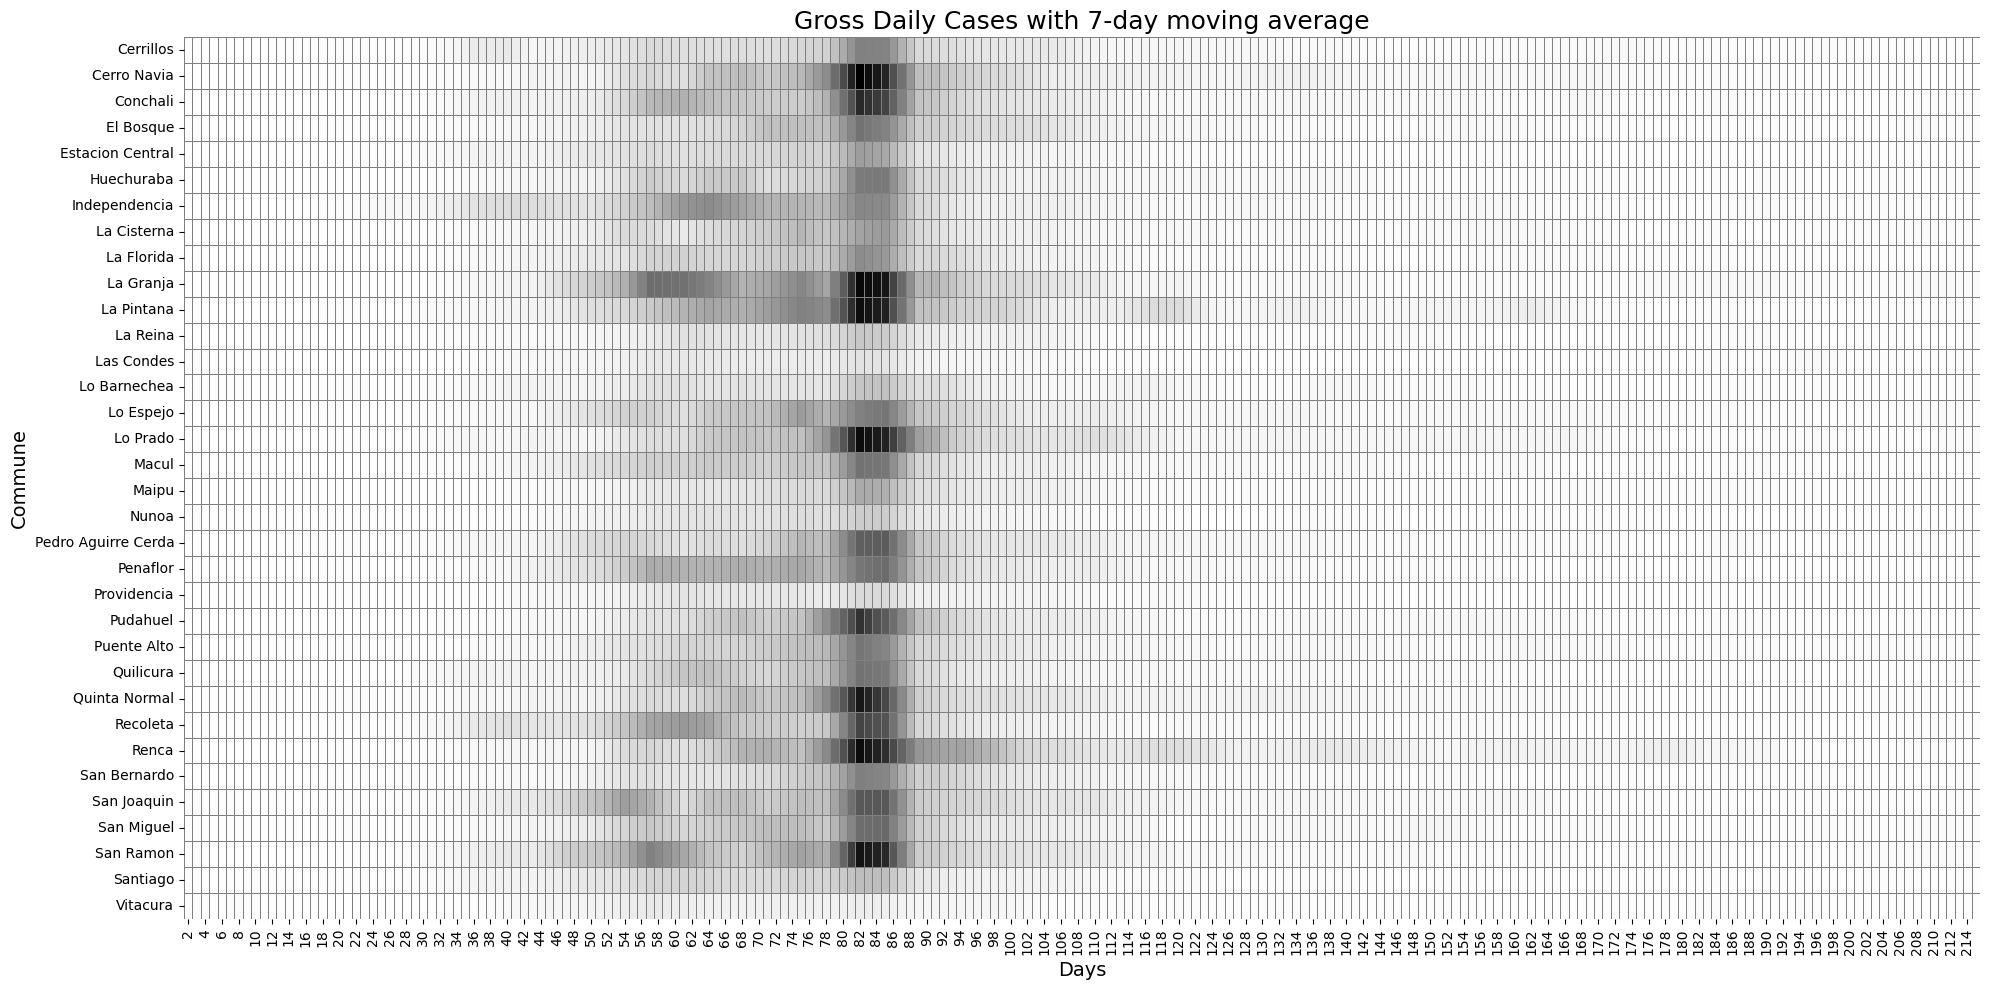

In [85]:
covid_pivot = covid_data.pivot(index='Commune', columns='Days', values='Gross_Daily_Cases_Mobile_Average_7_Days')

plt.figure(figsize=(20, 10))
sns.heatmap(
    covid_pivot,
    cmap='Greys', 
    linewidths=0.5,
    linecolor='gray',
    cbar=False  
)

plt.title('Gross Daily Cases with 7-day moving average', fontsize=18)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Commune', fontsize=14)

plt.tight_layout()

plt.show()

### Internal Mobility Index of each commune over time:

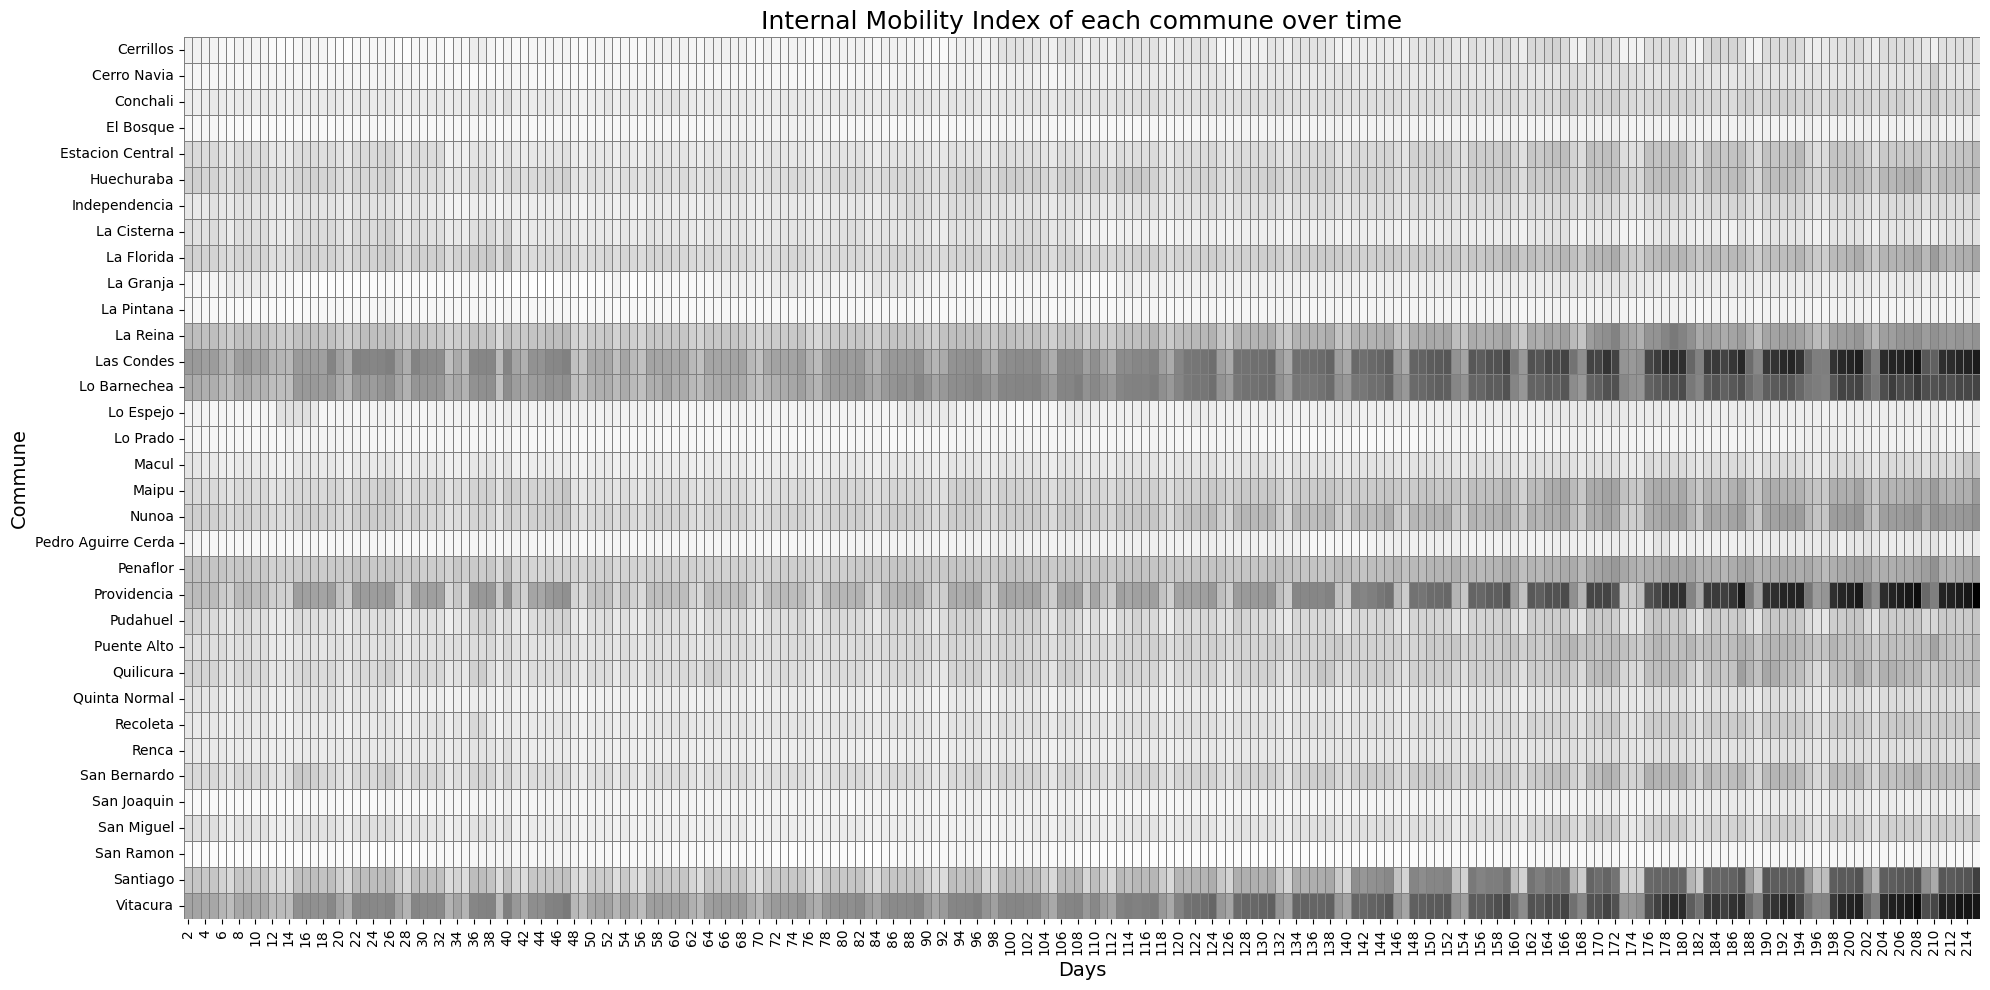

In [31]:
covid_pivot = covid_data.pivot(index='Commune', columns='Days', values='Internal_Mobility_Index')

# Crear el heatmap sin la barra de color (cbar=False)
plt.figure(figsize=(20, 10))
sns.heatmap(
    covid_pivot,
    cmap='Greys',  # Usar los colores personalizados
    linewidths=0.5,
    linecolor='gray',
    cbar=False  # Desactivar la barra de color
)

# Títulos y etiquetas
plt.title('Internal Mobility Index of each commune over time', fontsize=18)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Commune', fontsize=14)

# Ajustar el espaciado para evitar bordes innecesarios
plt.tight_layout()

# Mostrar el gráfico
plt.show()

### External Mobility Index of each commune over time:

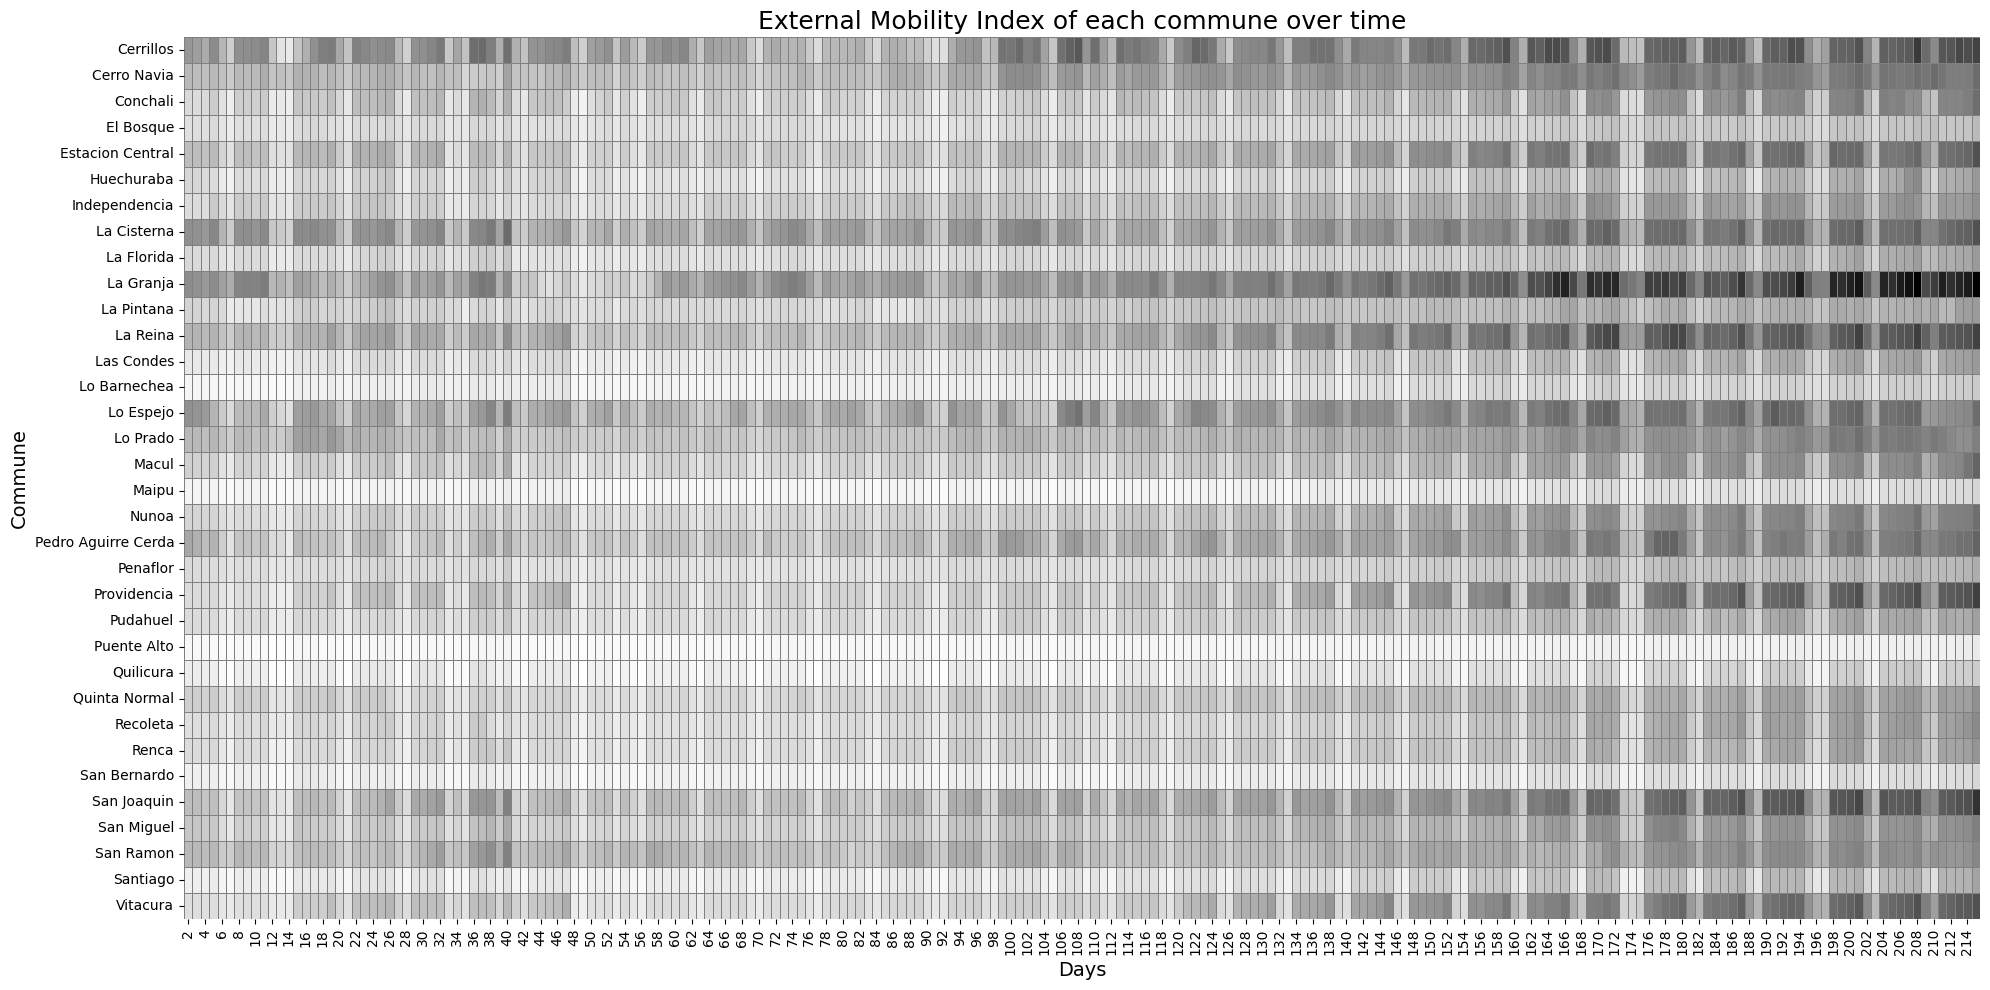

In [32]:
covid_pivot = covid_data.pivot(index='Commune', columns='Days', values='External_Mobility_Index')


plt.figure(figsize=(20, 10))
sns.heatmap(
    covid_pivot,
    cmap='Greys', 
    linewidths=0.5,
    linecolor='gray',
    cbar=False  
)

plt.title('External Mobility Index of each commune over time', fontsize=18)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Commune', fontsize=14)

plt.tight_layout()

plt.show()

### Step by Step Plan:

In [33]:
covid_data['Step_Label'].unique()

array(['Sin Medida', 'Cuarentena', 'Transición', 'Preparación',
       'Apertura'], dtype=object)

In [34]:
# Rearrange the Step by Step_Label
remap_step = {'Sin Medida': 'Unrestricted', 'Cuarentena': 'Quarantine', 'Transición':'Transition', 'Preparación':'Preparation','Apertura':'Opening'}
covid_data['Step_Label'] = covid_data['Step_Label'].map(remap_step)

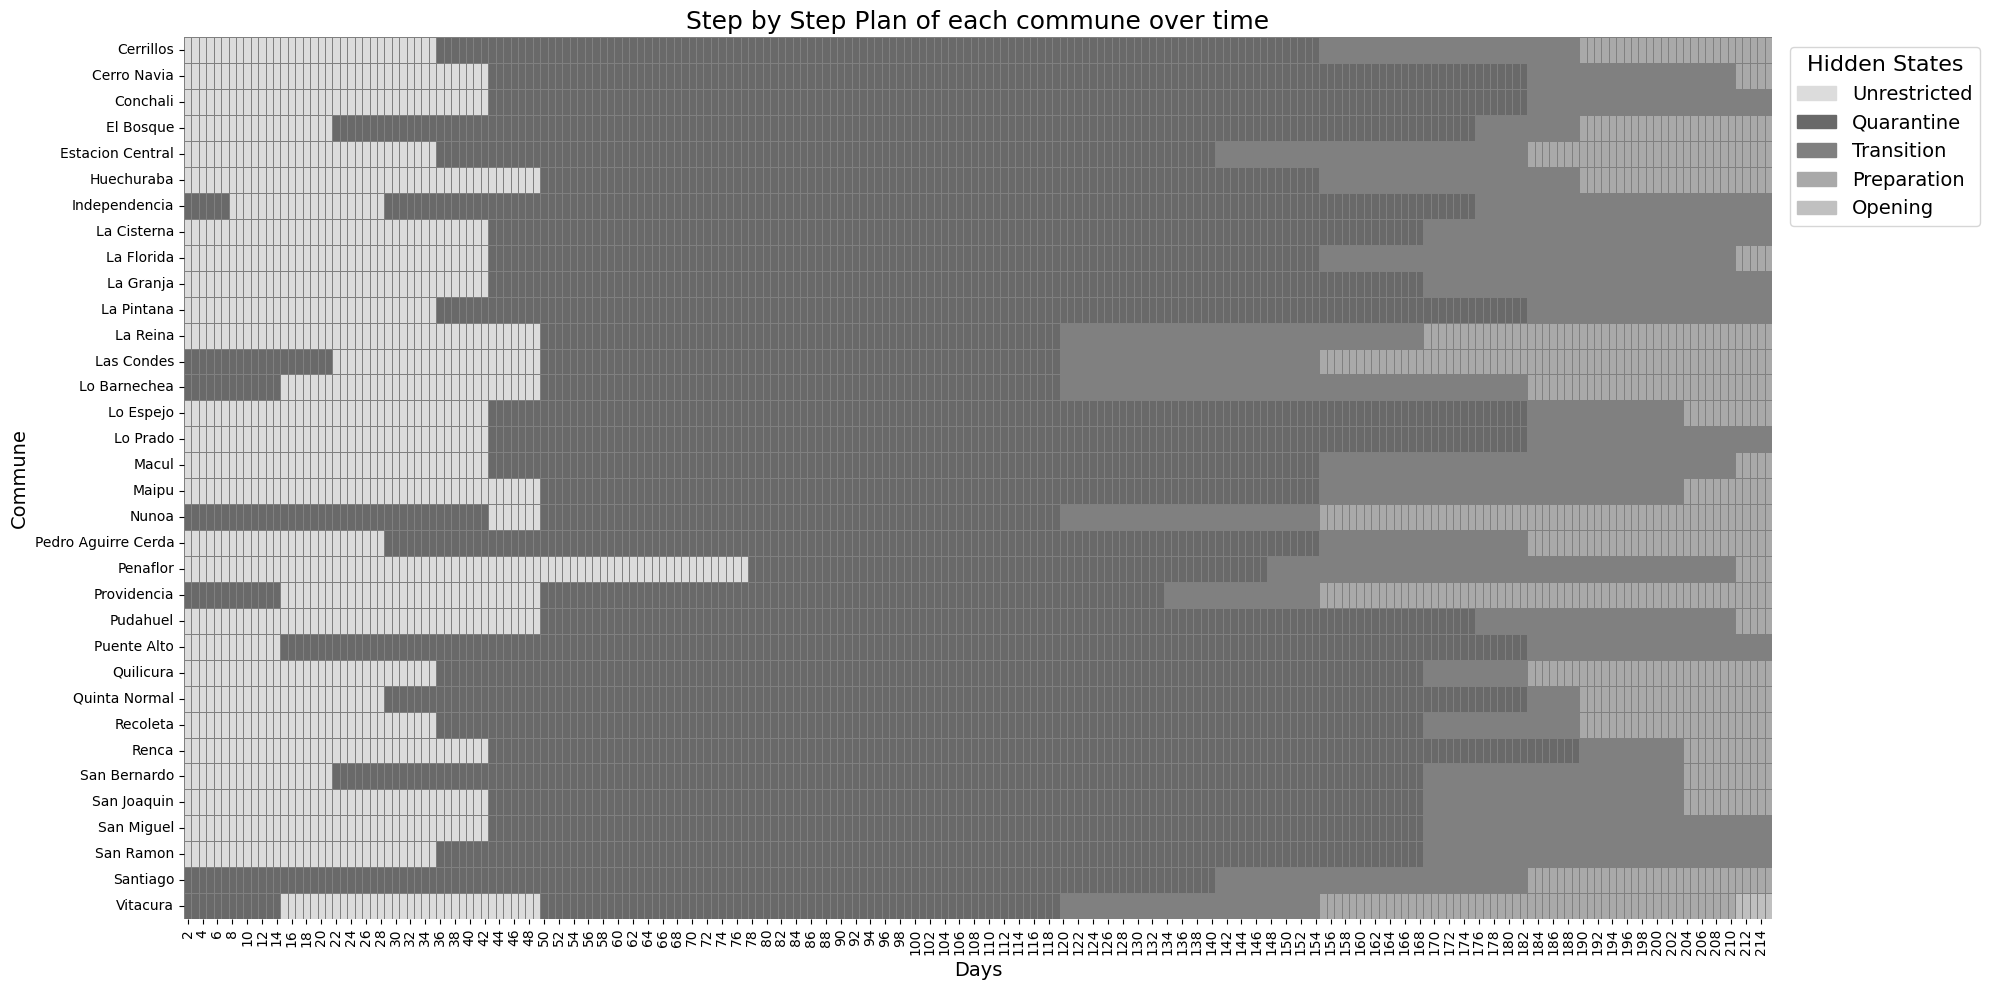

In [35]:
covid_pivot = covid_data.pivot(index='Commune', columns='Days', values='Step')

custom_colors = ['#DCDCDC','#696969', '#808080', '#A9A9A9','#C0C0C0' ]

plt.figure(figsize=(20, 10))
sns.heatmap(
    covid_pivot,
    #cmap='Greys', 
    cmap=sns.color_palette(custom_colors, as_cmap=True),  # Use the custom colors
    linewidths=0.5,
    linecolor='gray',
    cbar=False  
)




# Create a custom caption
legend_labels = covid_data['Step_Label'].unique()  # State labels
legend_handles = [mpatches.Patch(color=color, label=label) for color, label in zip(custom_colors, legend_labels)]

# Add the legend closer
plt.legend(
    handles=legend_handles, 
    title="Hidden States", 
    bbox_to_anchor=(1.005, 1), 
    loc='upper left',          
    fontsize=14,               
    title_fontsize=16,        
)


plt.title('Step by Step Plan of each commune over time', fontsize=18)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Commune', fontsize=14)

plt.tight_layout()

plt.show()

## Definition of HMM model formulas:

Create `ntimes` from clean data

In [38]:
# Create `ntimes` from clean data
ntimes = IntVector(covid_data.groupby("Commune")["Days"].count().tolist())

# Validate consistency:
print(sum(ntimes))        # Total observations (must match len(covid_data))
print(len(covid_data))    # To check alignment

7276
7276


### Convert to R format:

In [39]:
pandas2ri.activate()
covid_data_r = pandas2ri.py2rpy(covid_data)

The transition probabilities between states depend on the covariates ‘IM_internal’, ‘IM_external’ and the commune

In [40]:
# Main observation:
hmm_formula = r("as.formula")("Gross_Daily_Cases_Mobile_Average_7_Days ~ 1")

# Transition covariates:
trans_formula = r("as.formula")("~ Internal_Mobility_Index + External_Mobility_Index + Commune")

# Distribution of observation:
gaussian_family = r['gaussian']()

### Creation of the HMM model:

In [41]:
hmm_model = depmixS4.depmix( 
    response=hmm_formula, # Main observation
    nstates=3,  # Number of hidden states
    family=gaussian_family,  # Distribution of observation
    data=covid_data_r, # Data
    transition=trans_formula, # Transition covariates
    ntimes=ntimes # Number of observations per group
)

print("HMM model configured:")
print(hmm_model)

HMM model configured:
Initial state probabilities model 
  pr1   pr2   pr3 
0.333 0.333 0.333 

Transition model for state (component) 1 
Model of type multinomial (mlogit), formula: ~Internal_Mobility_Index + External_Mobility_Index + Commune
Coefficients: 
                           St1 St2 St3
(Intercept)                  0   0   0
Internal_Mobility_Index      0   0   0
External_Mobility_Index      0   0   0
CommuneCerro Navia           0   0   0
CommuneConchali              0   0   0
CommuneEl Bosque             0   0   0
CommuneEstacion Central      0   0   0
CommuneHuechuraba            0   0   0
CommuneIndependencia         0   0   0
CommuneLa Cisterna           0   0   0
CommuneLa Florida            0   0   0
CommuneLa Granja             0   0   0
CommuneLa Pintana            0   0   0
CommuneLa Reina              0   0   0
CommuneLas Condes            0   0   0
CommuneLo Barnechea          0   0   0
CommuneLo Espejo             0   0   0
CommuneLo Prado              0   0   0


## Model adjustment:

In [42]:
# Adjust the HMM model
hmm_fitted = depmixS4.fit(hmm_model)

# Verify adjusted model information
print("\nAdjusted HMM model:")
print(hmm_fitted)


converged at iteration 39 with logLik: -22164.39 

Adjusted HMM model:
Convergence info: Log likelihood converged to within tol. (relative change) 
'log Lik.' -22164.39 (df=224)
AIC:  44776.78 
BIC:  46320.67 



## Extract sequence of states (Viterbi) and join with data:

In [43]:
# Extract the most probable sequence of states (Viterbi path and probabilities)
posterior_probs = r['slot'](hmm_fitted, "posterior")

# Convert posterior_probs to pandas DataFrame
viterbi_df = pandas2ri.rpy2py(posterior_probs).reset_index(drop=True)
viterbi_df['row_id'] = viterbi_df.index

### Merged with the original data:

In [44]:
viterbi_merged = pd.merge(viterbi_df, covid_data, on='row_id', how='inner')
print(viterbi_merged.head())

   state        S1            S2        S3  row_id  Internal_Mobility_Index  \
0    3.0  0.000000  0.000000e+00  1.000000       0                 1.970381   
1    3.0  0.000275  8.638053e-11  0.999725       1                 1.845790   
2    3.0  0.000348  6.453303e-07  0.999652       2                 1.678598   
3    3.0  0.000581  3.874640e-07  0.999418       3                 1.736766   
4    3.0  0.000707  6.989014e-06  0.999286       4                 1.331296   

   External_Mobility_Index  Per_Capita_Income  Cumulative_Cases_Rate  \
0                 7.804008          267197.56               2.248303   
1                 7.471452          267197.56               4.496605   
2                 6.891732          267197.56               4.496605   
3                 8.317872          267197.56               4.496605   
4                 6.378498          267197.56               4.496605   

   Average_Household_Persons  ...                Priority_2020   Code  Year  \
0            

In [45]:
# Rearrange the states to match the desired interpretation:
remap_estado = {1: 2, 2: 3, 3: 1}
viterbi_merged['Reordened_state'] = viterbi_merged['state'].map(remap_estado)


## Visualizations:

### Viterbi Sequence:

In [46]:
viterbi_merged.head()

,state,S1,S2,S3,row_id,Internal_Mobility_Index,External_Mobility_Index,Per_Capita_Income,Cumulative_Cases_Rate,Average_Household_Persons,...,Code,Year,Month,Step,Step_Label,Quarantine_Start_Date,Quarantine_End_Date,Gross_Daily_Cases,Gross_Daily_Cases_Mobile_Average_7_Days,Reordened_state
0,3.0,0.000000,0.000000e+00,1.000000,0,1.970381,7.804008,267197.56,2.248303,3.145581,...,13102,2020,3,0,Unrestricted,2020-05-05,2020-08-31,2.248303,2.248303,1
1,3.0,0.000275,8.638053e-11,0.999725,1,1.845790,7.471452,267197.56,4.496605,3.145581,...,13102,2020,4,0,Unrestricted,2020-05-05,2020-08-31,2.248303,2.248303,1
2,3.0,0.000348,6.453303e-07,0.999652,2,1.678598,6.891732,267197.56,4.496605,3.145581,...,13102,2020,4,0,Unrestricted,2020-05-05,2020-08-31,0.000000,1.498868,1
3,3.0,0.000581,3.874640e-07,0.999418,3,1.736766,8.317872,267197.56,4.496605,3.145581,...,13102,2020,4,0,Unrestricted,2020-05-05,2020-08-31,0.000000,1.124151,1
4,3.0,0.000707,6.989014e-06,0.999286,4,1.331296,6.378498,267197.56,4.496605,3.145581,...,13102,2020,4,0,Unrestricted,2020-05-05,2020-08-31,0.000000,0.899321,1


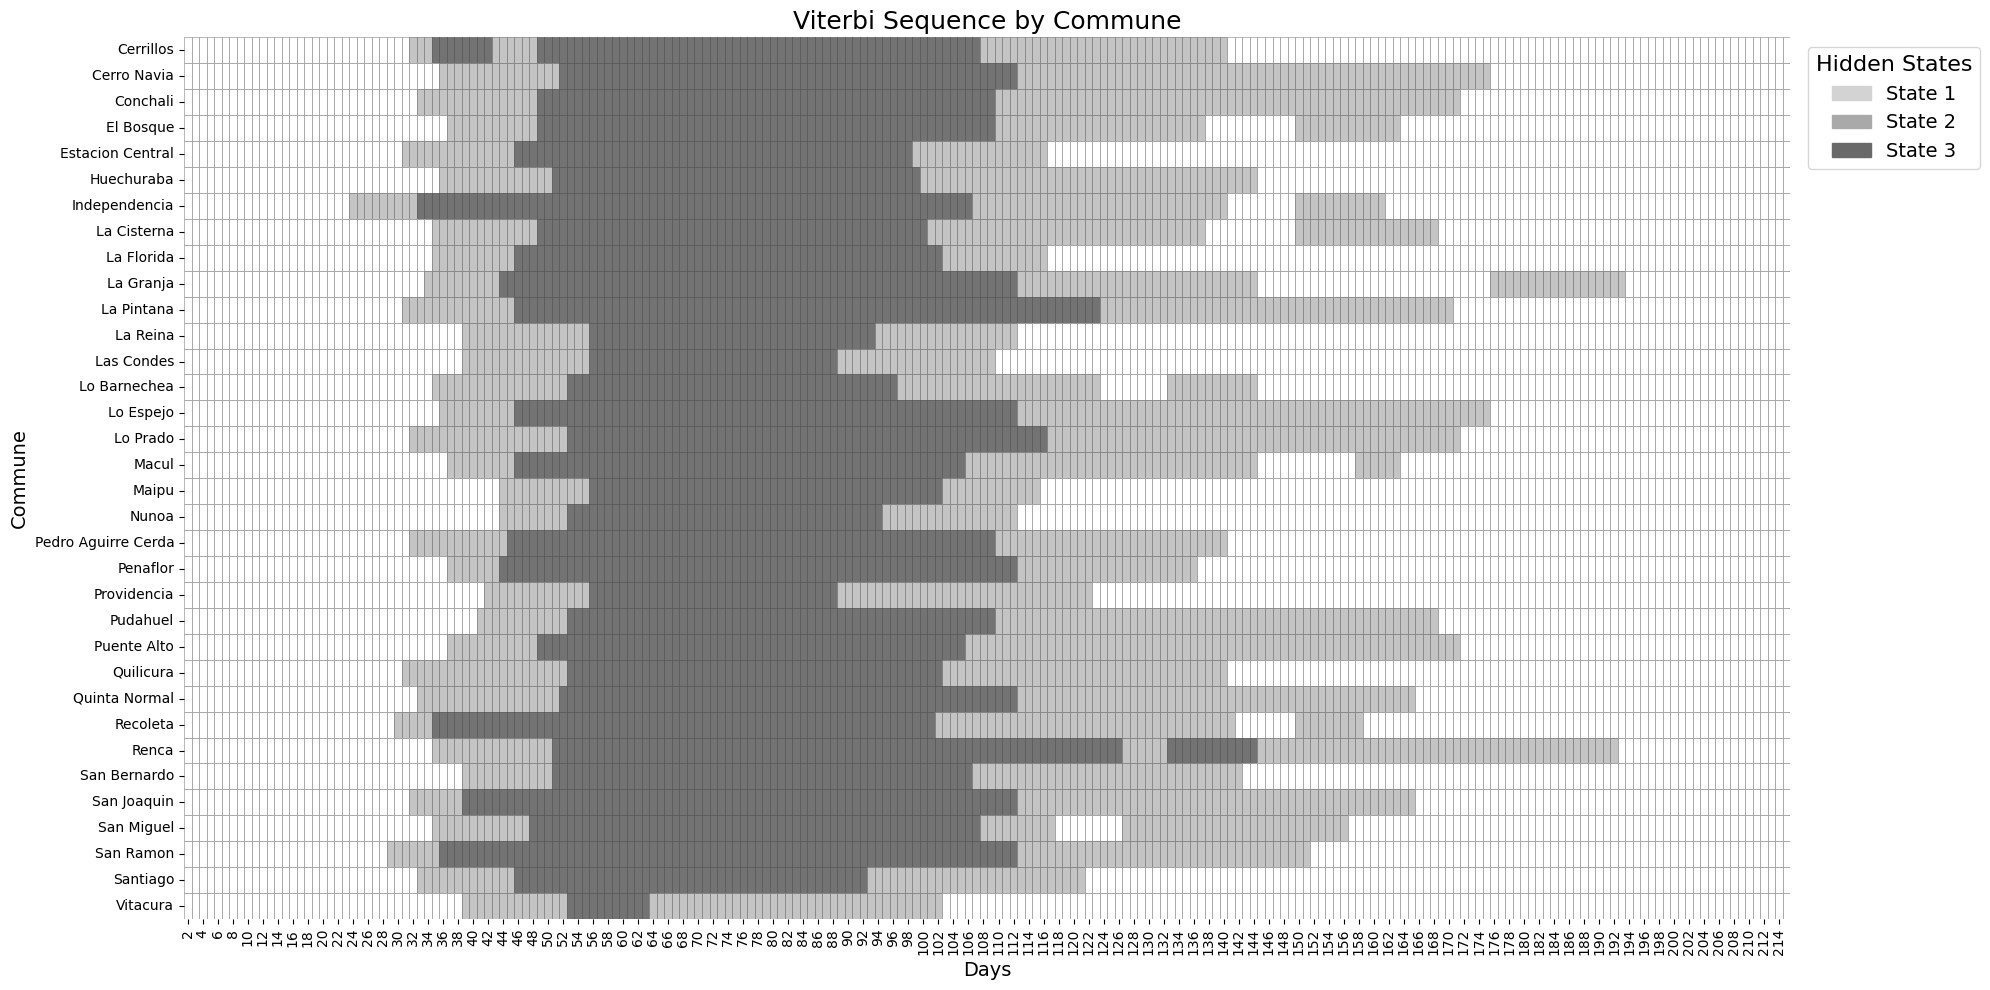

In [47]:
# Create the heatmap by pivoting the data
viterbi_pivot = viterbi_merged.pivot(index='Commune', columns='Days', values='Reordened_state')

# Define custom colors for each state
# Use custom colors for the states
#custom_colors = ['PeachPuff','LightSalmon', 'Tomato']  # Tomato (Severo)
# custom_colors grays
custom_colors= ['#D3D3D3', '#A9A9A9', '#696969']  # Light gray, medium gray and dark gray
# Create the mapping for the states
custom_palette = dict(zip([1, 2, 3], custom_colors))

plt.figure(figsize=(20, 10))
sns.heatmap(
    viterbi_pivot,
    #cmap=custom_colors,  # Use custom colors
    cmap='Greys',
    linewidths=0.5,
    linecolor='gray',
    alpha=0.55,  # Adjusting transparency
    cbar=False  # Deactivate the color bar
)

# Create a custom caption
legend_labels = ['State 1', 'State 2','State 3']  # State labels
legend_handles = [mpatches.Patch(color=color, label=label) for color, label in zip(custom_colors, legend_labels)]

# Add the legend closer
plt.legend(
    handles=legend_handles, 
    title="Hidden States", 
    bbox_to_anchor=(1.005, 1), 
    loc='upper left',          
    fontsize=14,               
    title_fontsize=16,        
)

# Titles and labels
plt.title('Viterbi Sequence by Commune', fontsize=18)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Commune', fontsize=14)


plt.tight_layout()

plt.show()

# Characterization of Hidden States:

In [50]:
eda_data = viterbi_merged[['Reordened_state', 'Internal_Mobility_Index', 'External_Mobility_Index', 'Cumulative_Cases_Rate', 
                             'Gross_Daily_Cases', 'Gross_Daily_Cases_Mobile_Average_7_Days', 
                             'Per_Capita_Income', 'Average_Household_Persons', 
                             'Inmigrants', 'Total_Households_Housed',
                              'Housing_Precariousness_Index', 'Higher_Education_Percentage', 'Social_Priority_Index_2020']]


C:\Users\ferna\AppData\Local\Temp\ipykernel_14732\3209932443.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1' '1' '1' ... '1' '1' '1']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  eda_data.loc[:, 'Reordened_state'] = eda_data['Reordened_state'].astype(str)


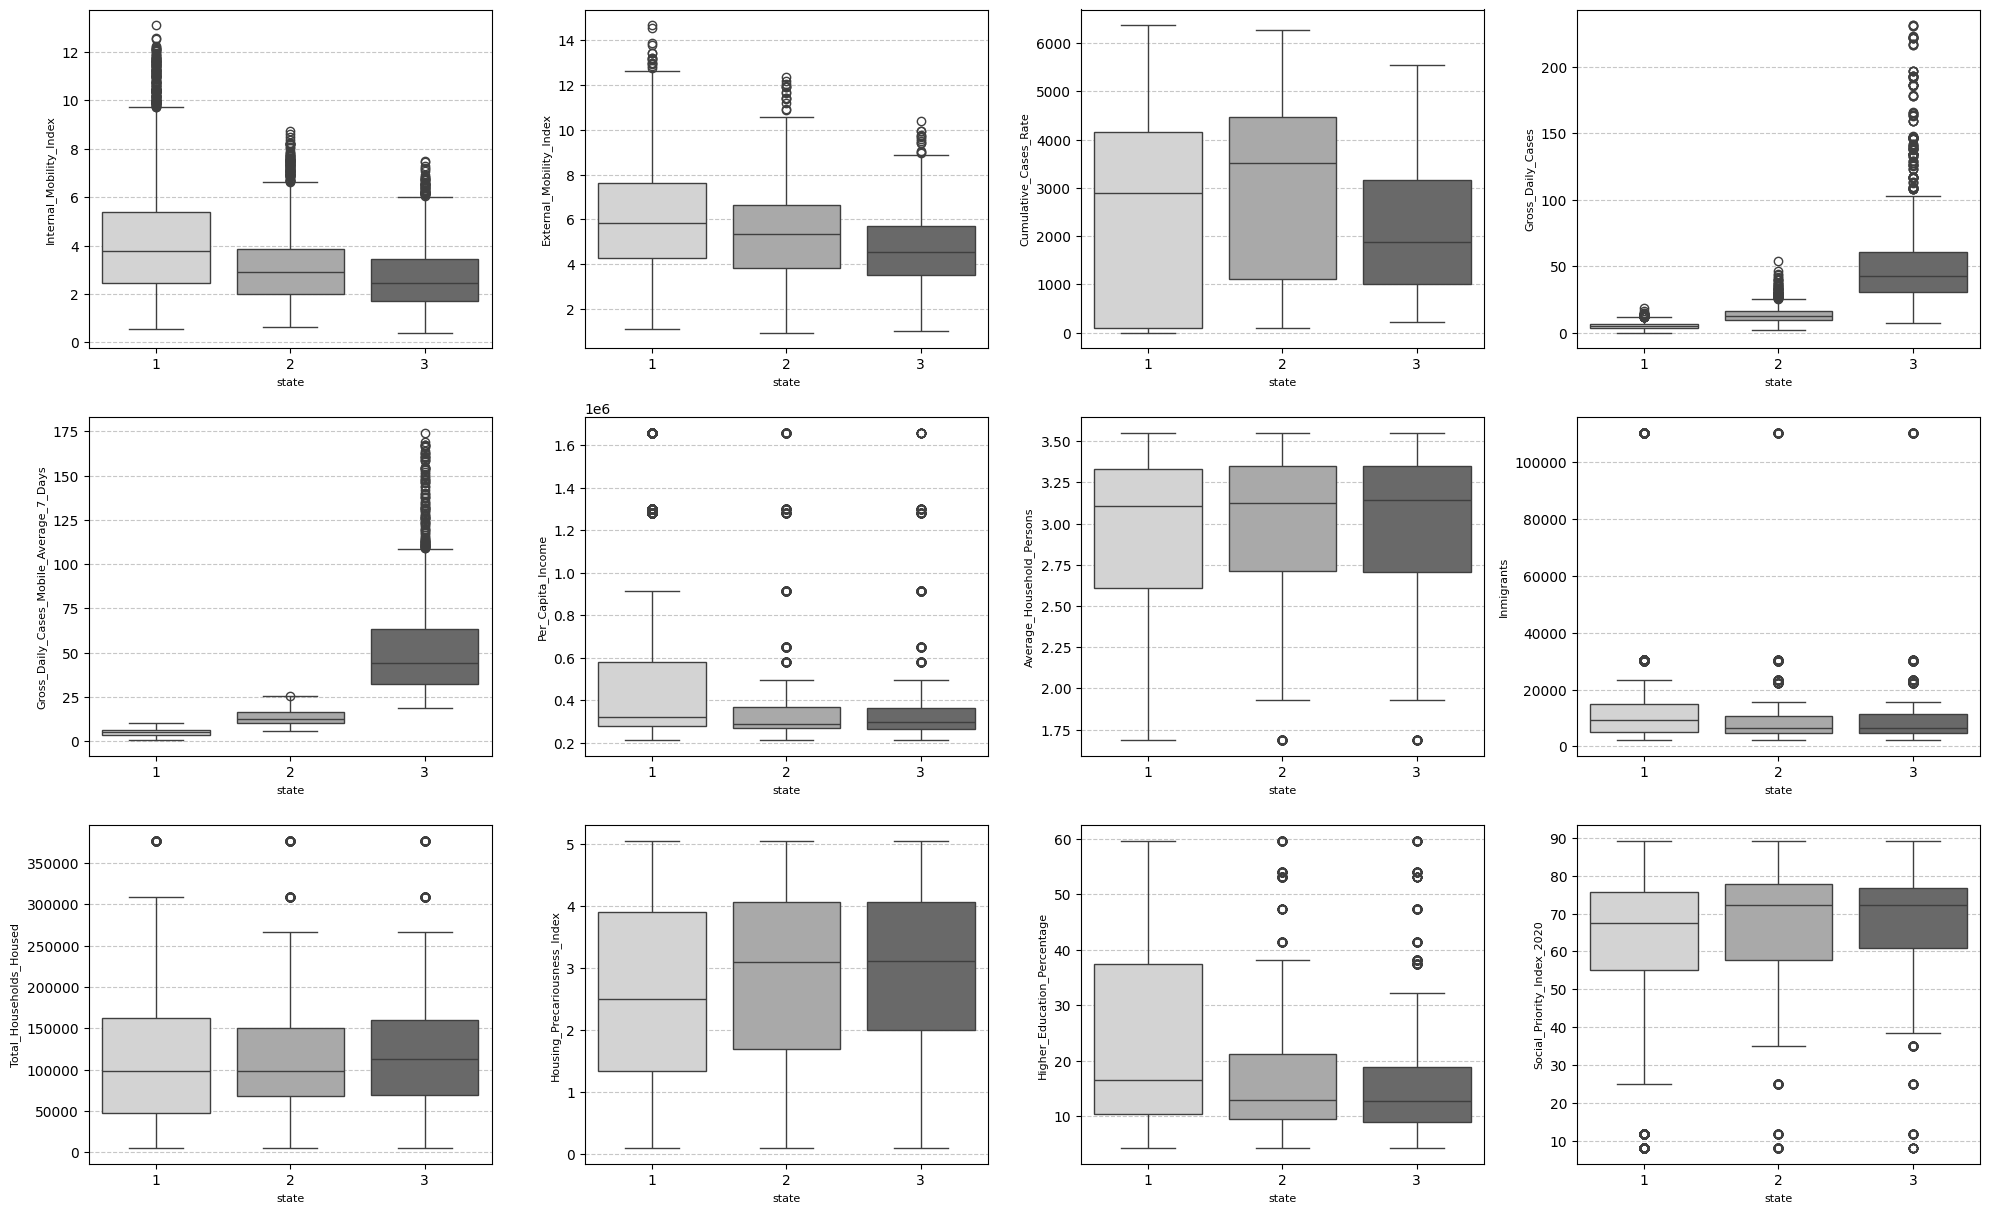

In [51]:
# Convertir la columna 'state' a cadenas con formato flotante
eda_data.loc[:, 'Reordened_state'] = eda_data['Reordened_state'].astype(str)

# Definir la paleta de colores basada en severidad
custom_palette = {
    '1': '#D3D3D3',  # Leve
    '2': '#A9A9A9',  # Moderado
    '3': '#696969'   # Severo
}

# Variables que queremos graficar
variables = ['Internal_Mobility_Index', 'External_Mobility_Index', 'Cumulative_Cases_Rate', 
                             'Gross_Daily_Cases', 'Gross_Daily_Cases_Mobile_Average_7_Days', 
                             'Per_Capita_Income', 'Average_Household_Persons', 
                             'Inmigrants', 'Total_Households_Housed',
                              'Housing_Precariousness_Index', 'Higher_Education_Percentage', 'Social_Priority_Index_2020']

# Configuración de la figura
n_rows = 5  # Número de filas
n_cols = 4  # Número de columnas
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))  # Ajusta el tamaño total

# Aplanar los ejes para iterar más fácilmente
axes = axes.ravel()

# Crear los boxplots para cada variable sin leyendas individuales
for i, var in enumerate(variables):
    sns.boxplot(data=eda_data, x='Reordened_state', y=var, hue='Reordened_state', palette=custom_palette, ax=axes[i], dodge=False)
    #axes[i].legend_.remove()  # Eliminar leyenda individual
    #axes[i].set_title(f'{var}', fontsize=10)
    axes[i].set_xlabel('state', fontsize=8)
    axes[i].set_ylabel(var, fontsize=8)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# Eliminar cualquier subplot sobrante si hay más ejes que gráficos
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])

# Ajustar el espacio entre subplots
plt.tight_layout()
plt.show()

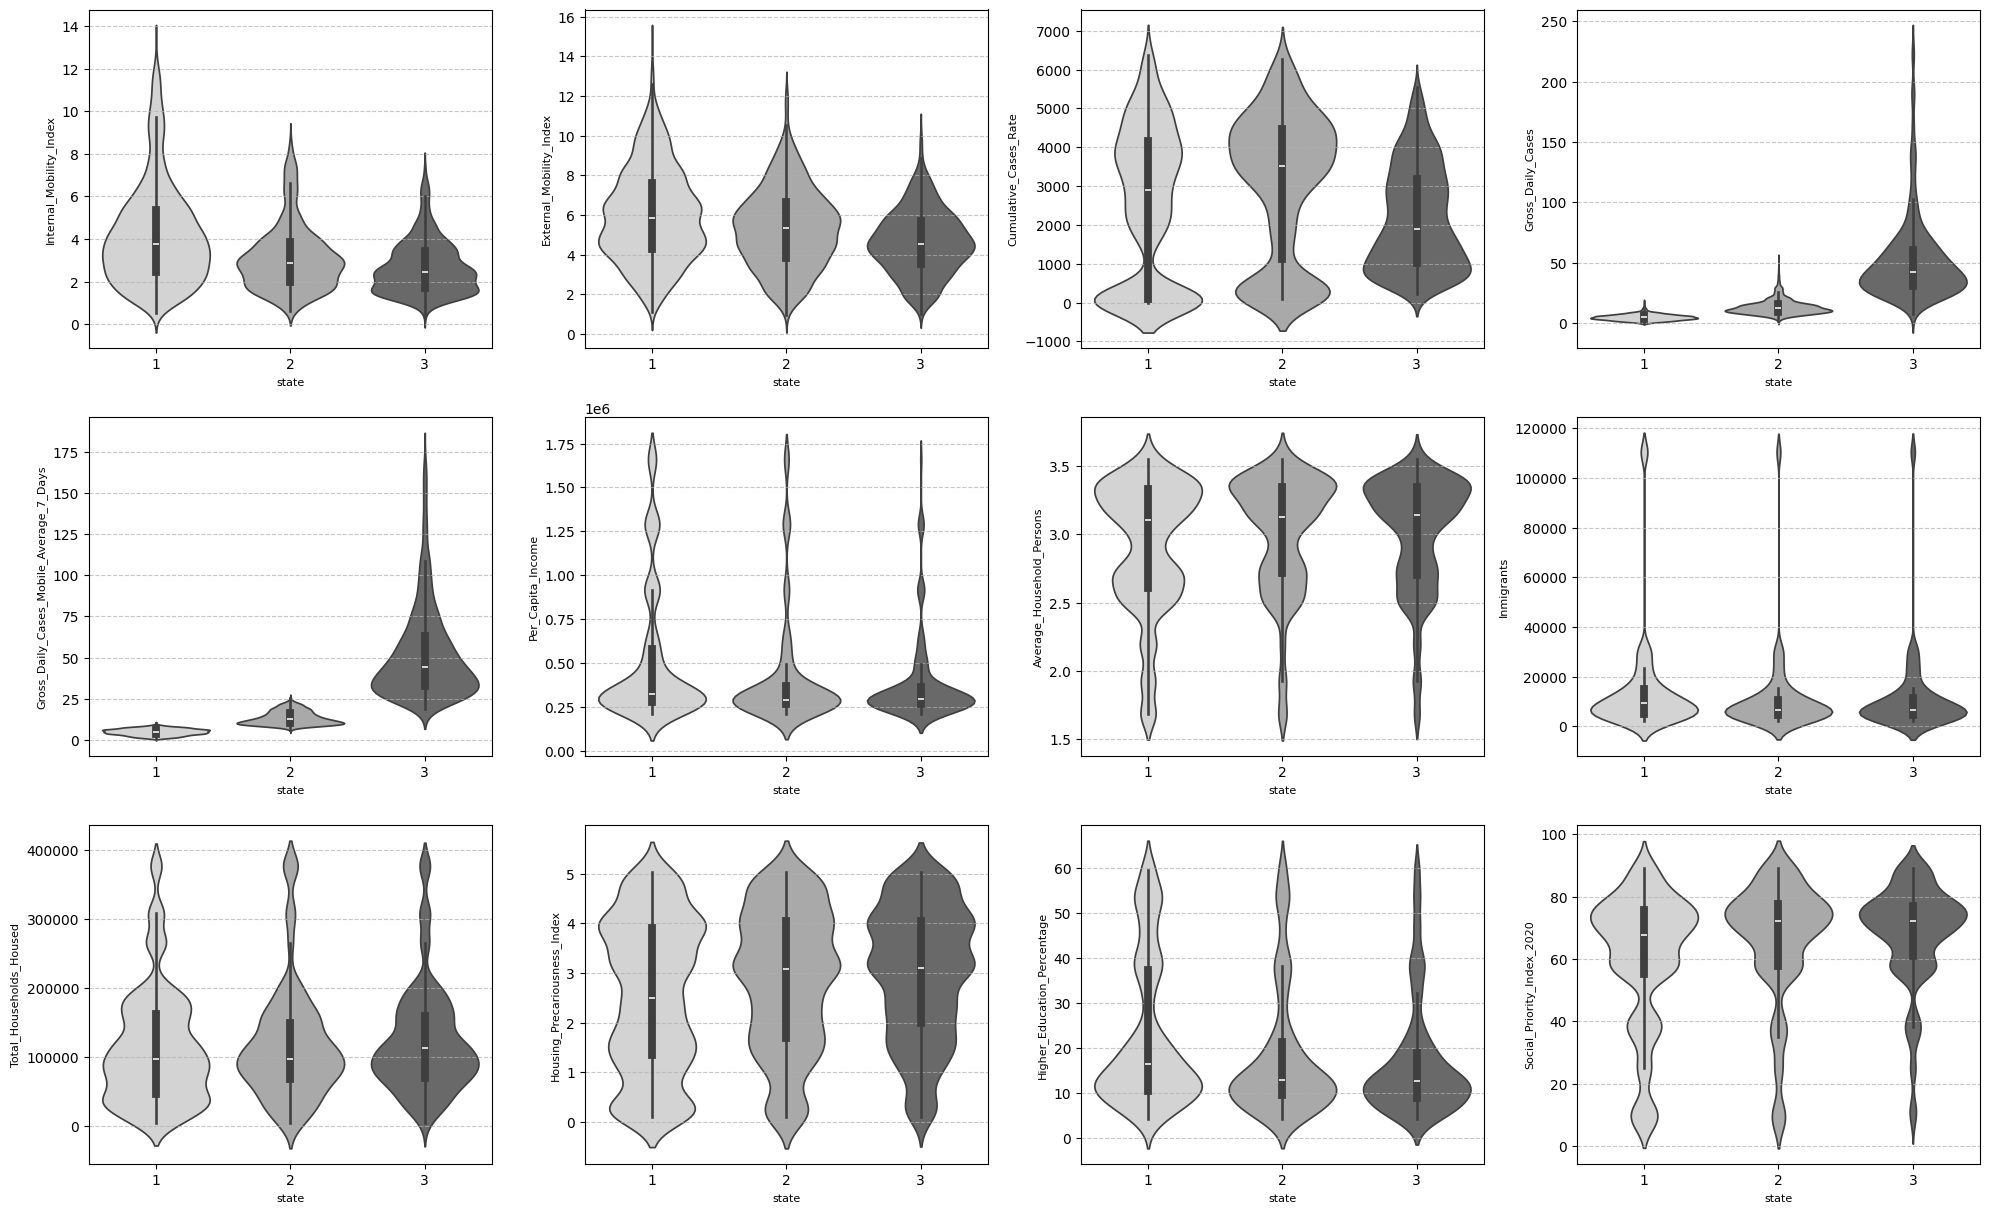

In [87]:
# Violinplots:
custom_palette = {
    '1': '#D3D3D3',  # Leve
    '2': '#A9A9A9',  # Moderado
    '3': '#696969'   # Severo
}

# Configuración de la figura
n_rows = 5  # Número de filas
n_cols = 4  # Número de columnas
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))  # Ajusta el tamaño total

# Aplanar los ejes para iterar más fácilmente
axes = axes.ravel()

# Crear los violintplots para cada variable sin leyendas individuales:
for i, var in enumerate(variables):
    sns.violinplot(data=eda_data, x='Reordened_state', y=var, hue='Reordened_state', palette=custom_palette, ax=axes[i], dodge=False)
    #axes[i].legend_.remove()  # Eliminar leyenda individual
    #axes[i].set_title(f'{var}', fontsize=10)
    axes[i].set_xlabel('state', fontsize=8)
    axes[i].set_ylabel(var, fontsize=8)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)


# Eliminar cualquier subplot sobrante si hay más ejes que gráficos
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])

# Ajustar el espacio entre subplots
plt.tight_layout()
plt.show()

#### Number of days per state for each commune

In [ ]:
state_count = viterbi_merged.groupby(['Commune', 'Reordened_state']).size().reset_index(name='Days')

Number of days per state for each commune:
         Commune  Reordened_state  Days
0      Cerrillos                1   105
1      Cerrillos                2    42
2      Cerrillos                3    67
3    Cerro Navia                1    74
4    Cerro Navia                2    79
..           ...              ...   ...
97      Santiago                2    42
98      Santiago                3    47
99      Vitacura                1   150
100     Vitacura                2    53
101     Vitacura                3    11

[102 rows x 3 columns]


In [55]:
state_count[state_count['Commune']=='Vitacura'].sort_values(by='Days', ascending=False)

,Commune,Reordened_state,Days
99,Vitacura,1,150
100,Vitacura,2,53
101,Vitacura,3,11


In [64]:
state_count[state_count['Commune']=='La Pintana'].sort_values(by='Days', ascending=False)

,Commune,Reordened_state,Days
32,La Pintana,3,78
30,La Pintana,1,74
31,La Pintana,2,62


In [70]:
state_count.head()

,Commune,Reordened_state,Days
0,Cerrillos,1,105
1,Cerrillos,2,42
2,Cerrillos,3,67
3,Cerro Navia,1,74
4,Cerro Navia,2,79


C:\Users\ferna\AppData\Local\Temp\ipykernel_14732\245686125.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=state_count, x='Days', y='Commune', orient='h',hue='Reordened_state', palette=custom_colors, dodge=True, ci=None)


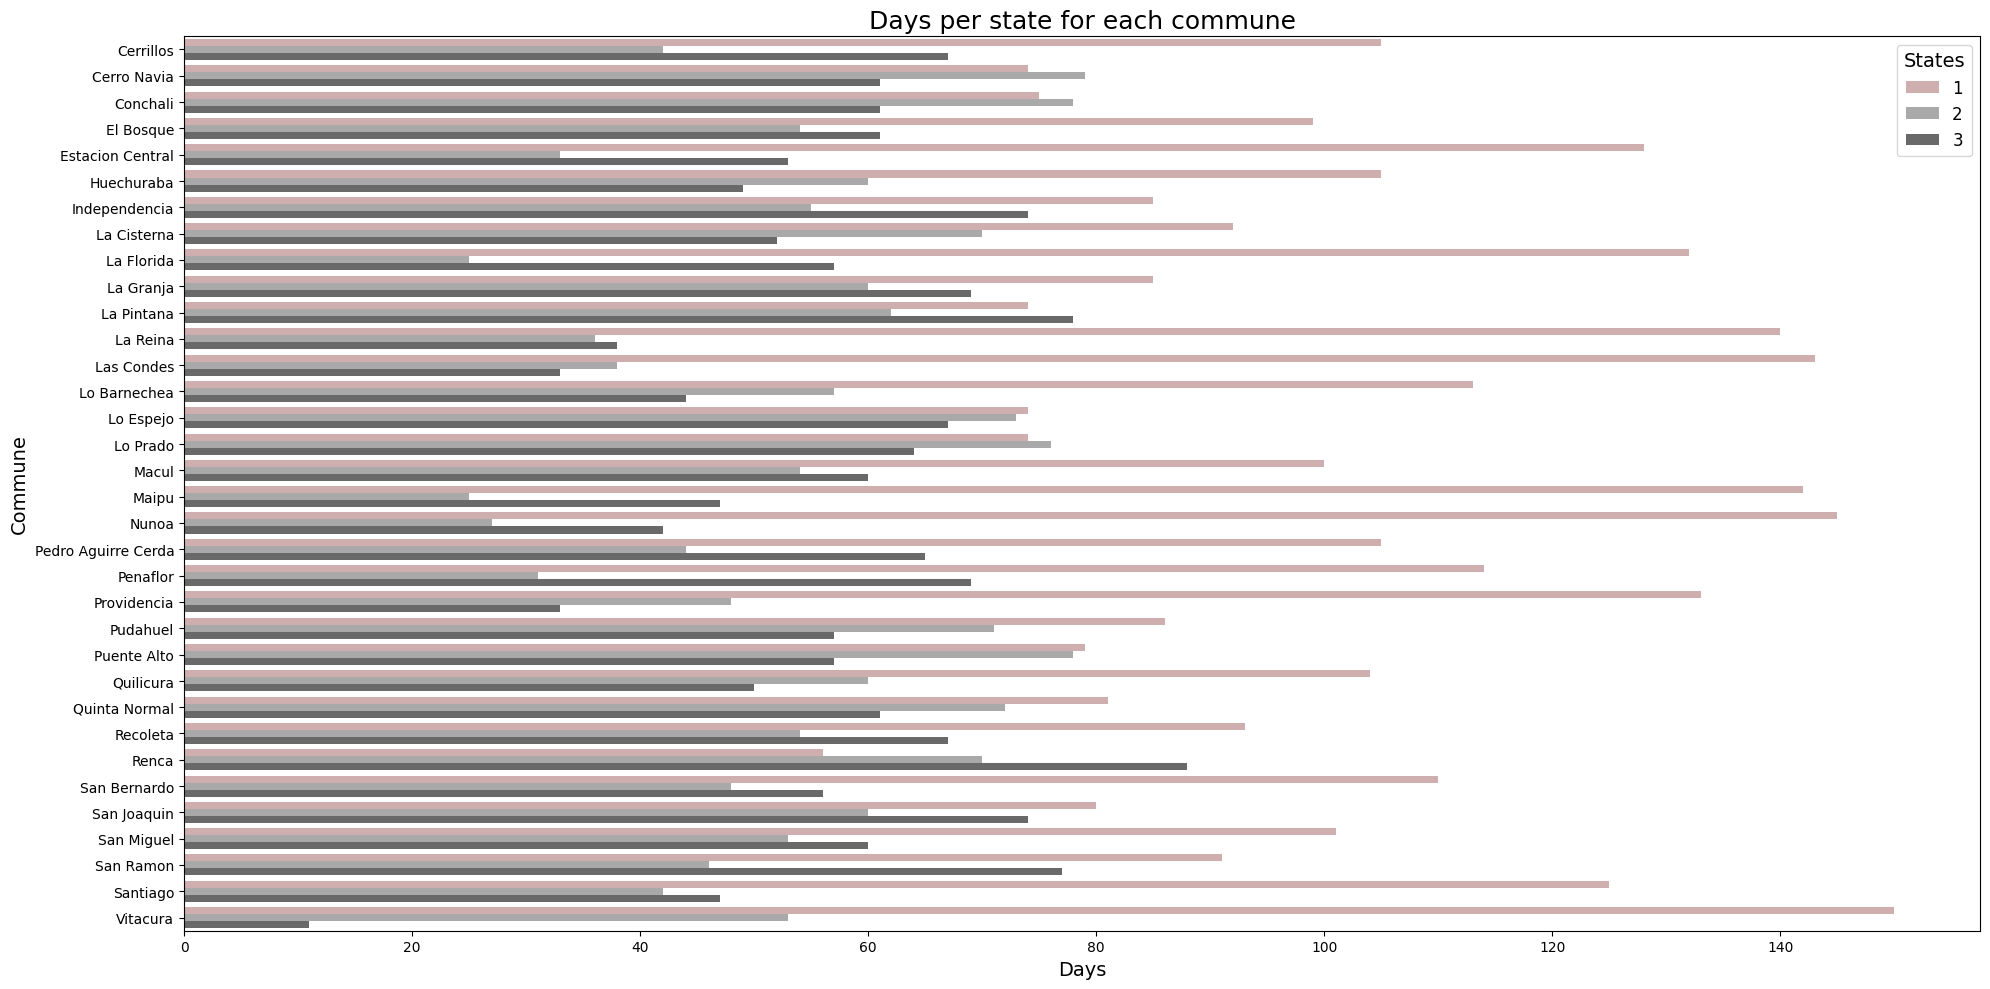

In [82]:
# barplot:
plt.figure(figsize=(20, 10))
custom_palette = {
    '1': '#D3A9A9',  # Leve
    '2': '#A9A9A9',  # Moderado
    '3': '#696969'   # Severo
}
custom_colors= ['#D3A9A9', '#A9A9A9', '#696969']  # Light gray, medium gray and dark gray
sns.barplot(data=state_count, x='Days', y='Commune', orient='h',hue='Reordened_state', palette=custom_colors, dodge=True, ci=None)
plt.title('Days per state for each commune', fontsize=18)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Commune', fontsize=14)
plt.xticks()
plt.legend(title='States', fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()


## Transition probabilites between states:

In [ ]:
# Extract the adjusted transition matrix
transition_matrix = r['slot'](hmm_fitted, "trDens")
print("\nAdjusted transition matrix:")
print(transition_matrix)


Matriz de transición ajustada:
[[[9.88006681e-01 1.91888104e-03 7.73190168e-03]
  [1.05865720e-02 9.98081119e-01 1.69924867e-09]
  [1.40674676e-03 3.67625265e-16 9.92268097e-01]]

 [[9.81706807e-01 8.73606558e-04 8.87355680e-03]
  [1.75687684e-02 9.99126393e-01 2.41835629e-09]
  [7.24424309e-04 3.99844034e-17 9.91126441e-01]]

 [[9.62216407e-01 2.39731211e-04 1.01469551e-02]
  [3.75528066e-02 9.99760269e-01 3.91683538e-09]
  [2.30786421e-04 1.16159816e-18 9.89853041e-01]]

 ...

 [[2.16388781e-04 2.64861861e-11 4.27939964e-07]
  [2.62212713e-14 9.60740124e-20 2.18025294e-15]
  [9.99783611e-01 1.00000000e+00 9.99999572e-01]]

 [[1.98407498e-04 2.49488939e-11 4.48450043e-07]
  [2.39088527e-14 8.43894692e-20 2.24904655e-15]
  [9.99801593e-01 1.00000000e+00 9.99999552e-01]]

 [[9.83970739e-05 1.49492944e-11 6.45279779e-07]
  [1.11792612e-14 2.85247723e-20 2.84130668e-15]
  [9.99901603e-01 1.00000000e+00 9.99999355e-01]]]


In [ ]:
# Restructure transition_matrix to obtain transition probabilities per sample
n_samples, n_states, _ = transition_matrix.shape

# Remapping state indexes
transitions_list = []
for t in range(n_samples):
    for i in range(n_states):
        for j in range(n_states):
            transitions_list.append({
                "sample": t,
                f"Trans_{i+1}->{j+1}": transition_matrix[t, i, j]  
            })

transitions_df = pd.DataFrame(transitions_list).groupby("sample").mean().reset_index(drop=True)

# Reordering State Transitions:
remap_transition_states = {'Trans_1->1':'Trans_2->2','Trans_1->2':'Trans_2->3','Trans_1->3':'Trans_2->1','Trans_2->2':'Trans_3->3','Trans_2->3':'Trans_3->1',
                           'Trans_3->1':'Trans_1->2','Trans_3->2':'Trans_1->3','Trans_3->3':'Trans_1->1','Trans_2->1':'Trans_3->2'}

# Apply transitions name mapping
transitions_df = transitions_df.rename(columns=remap_transition_states)



print("Structured transitions:")
print(transitions_df.head())


Transiciones estructuradas:
   Trans_2->2  Trans_2->3  Trans_2->1  Trans_3->2  Trans_3->3    Trans_3->1  \
0    0.988007    0.001919    0.007732    0.010587    0.998081  1.699249e-09   
1    0.981707    0.000874    0.008874    0.017569    0.999126  2.418356e-09   
2    0.962216    0.000240    0.010147    0.037553    0.999760  3.916835e-09   
3    0.984126    0.003281    0.015371    0.012664    0.996719  3.049639e-09   
4    0.890539    0.000056    0.017375    0.109388    0.999944  1.016508e-08   

   Trans_1->2    Trans_1->3  Trans_1->1  
0    0.001407  3.676253e-16    0.992268  
1    0.000724  3.998440e-17    0.991126  
2    0.000231  1.161598e-18    0.989853  
3    0.003209  6.806549e-16    0.984629  
4    0.000072  1.358643e-20    0.982625  


In [124]:
# Selecting relevant covariates
covariates_df = viterbi_merged[[
    'Internal_Mobility_Index', 'External_Mobility_Index', 
    'Per_Capita_Income', 'Average_Household_Persons', 'Inmigrants', 
    'Total_Households_Housed', 'Housing_Precariousness_Index', 
    'Higher_Education_Percentage', 'Social_Priority_Index_2020'
]].reset_index(drop=True)

# Combine with transitions
analysis_df = pd.concat([covariates_df, transitions_df], axis=1)
print("Combined data for analysis:")
print(analysis_df.head())

Combined data for analysis:
   Internal_Mobility_Index  External_Mobility_Index  Per_Capita_Income  \
0                 1.970381                 7.804008          267197.56   
1                 1.845790                 7.471452          267197.56   
2                 1.678598                 6.891732          267197.56   
3                 1.736766                 8.317872          267197.56   
4                 1.331296                 6.378498          267197.56   

   Average_Household_Persons  Inmigrants  Total_Households_Housed  \
0                   3.145581        3606                    68120   
1                   3.145581        3606                    68120   
2                   3.145581        3606                    68120   
3                   3.145581        3606                    68120   
4                   3.145581        3606                    68120   

   Housing_Precariousness_Index  Higher_Education_Percentage  \
0                      3.395792                 

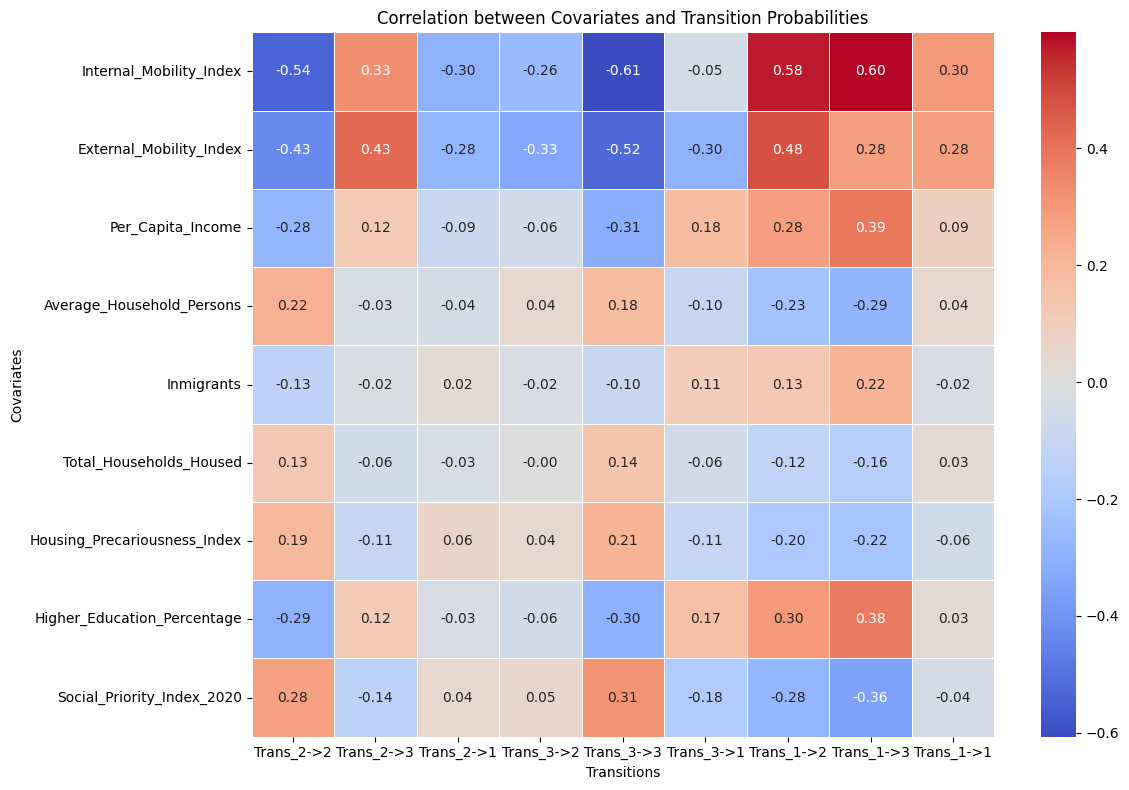

In [125]:
# Calculate the correlation matrix
correlations = analysis_df.corr().loc[
    covariates_df.columns, 
    transitions_df.columns
]

# Plot the heatmap of correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation between Covariates and Transition Probabilities")
plt.xlabel("Transitions")
plt.ylabel("Covariates")
plt.tight_layout()
plt.show()


In [126]:
viterbi_merged.columns

Index(['state', 'S1', 'S2', 'S3', 'row_id', 'Internal_Mobility_Index',
       'External_Mobility_Index', 'Per_Capita_Income', 'Cumulative_Cases_Rate',
       'Average_Household_Persons', 'Inmigrants', 'Total_Households_Housed',
       'Housing_Precariousness_Index', 'Commune', 'Date', 'Days',
       'Higher_Education_Percentage', 'Postgraduade_Percentage',
       'Social_Priority_Index_2020', 'Priority_2020', 'Code', 'Year', 'Month',
       'Step', 'Step_Label', 'Quarantine_Start_Date', 'Quarantine_End_Date',
       'Gross_Daily_Cases', 'Gross_Daily_Cases_Mobile_Average_7_Days',
       'Reordened_state'],
      dtype='object')

In [ ]:

transitions = []


for idx, matriz in enumerate(transition_matrix):
    for from_state in range(len(matriz)):
        for to_state in range(len(matriz[from_state])):
            transitions.append({
                'Original_Day':  viterbi_merged.iloc[idx]['Days'],  # Original day on final basis
                'Correlative_Day': idx,  # Index or correlative day generated
                'Commune': viterbi_merged.iloc[idx]['Commune'],  # Commune associated to the day
                'from_state': from_state + 1,  
                'to_state': to_state + 1,     
                'probability': matriz[from_state][to_state]
            })

transitions_df = pd.DataFrame(transitions)

transitions_df['Transition'] = (
    "Trans_" + transitions_df['from_state'].astype(str) + "->" + transitions_df['to_state'].astype(str)
)




In [128]:
transitions_df.head()

,Original_Day,Correlative_Day,Commune,from_state,to_state,probability,Transition
0,2,0,Cerrillos,1,1,0.988007,Trans_1->1
1,2,0,Cerrillos,1,2,0.001919,Trans_1->2
2,2,0,Cerrillos,1,3,0.007732,Trans_1->3
3,2,0,Cerrillos,2,1,0.010587,Trans_2->1
4,2,0,Cerrillos,2,2,0.998081,Trans_2->2


In [129]:
# Rearrange the states to match the desired interpretation:
remap_transition_states = {'Trans_1->1':'Trans_2->2','Trans_1->2':'Trans_2->3','Trans_1->3':'Trans_2->1','Trans_2->2':'Trans_3->3','Trans_2->3':'Trans_3->1',
                           'Trans_3->1':'Trans_1->2','Trans_3->2':'Trans_1->3','Trans_3->3':'Trans_1->1','Trans_2->1':'Trans_3->2'}

transitions_df['Reordened_Transition'] = transitions_df['Transition'].map(remap_transition_states)

In [ ]:
# Pivot to have the transitions as columns
transitions_df = transitions_df.pivot(
    index=['Commune', 'Original_Day', 'Correlative_Day'],  # Add both day references
    columns='Reordened_Transition',
    values='probability'
).reset_index()


print("DataFrame of transitions updated:")
print(transitions_df.head())


DataFrame of transitions updated:
Reordened_Transition    Commune  Original_Day  Correlative_Day  Trans_1->1  \
0                     Cerrillos             2                0    0.992268   
1                     Cerrillos             3                1    0.991126   
2                     Cerrillos             4                2    0.989853   
3                     Cerrillos             5                3    0.984629   
4                     Cerrillos             6                4    0.982625   

Reordened_Transition  Trans_1->2    Trans_1->3  Trans_2->1  Trans_2->2  \
0                       0.001407  3.676253e-16    0.007732    0.988007   
1                       0.000724  3.998440e-17    0.008874    0.981707   
2                       0.000231  1.161598e-18    0.010147    0.962216   
3                       0.003209  6.806549e-16    0.015371    0.984126   
4                       0.000072  1.358643e-20    0.017375    0.890539   

Reordened_Transition  Trans_2->3    Trans_3->1  Tran

In [133]:
transitions_df.columns

Index(['Commune', 'Original_Day', 'Correlative_Day', 'Trans_1->1',
       'Trans_1->2', 'Trans_1->3', 'Trans_2->1', 'Trans_2->2', 'Trans_2->3',
       'Trans_3->1', 'Trans_3->2', 'Trans_3->3'],
      dtype='object', name='Reordened_Transition')

In [ ]:
# Convert transitions to “long” format
transitions_long = pd.melt(
    transitions_df,
    id_vars=['Commune', 'Original_Day', 'Correlative_Day'],  # Include both columns of days
    value_vars=['Trans_1->1', 'Trans_1->2', 'Trans_1->3', 
                'Trans_2->1', 'Trans_2->2', 'Trans_2->3', 
                'Trans_3->1', 'Trans_3->2', 'Trans_3->3'],
    var_name='Transition',
    value_name='Probability_Transition'
)

# Perform the merge to add the covariables from base_final
lmm_data = transitions_long.merge(
    viterbi_merged[['Commune', 'Days', 'Internal_Mobility_Index', 'External_Mobility_Index', 'Cumulative_Cases_Rate', 
                'Gross_Daily_Cases', 'Gross_Daily_Cases_Mobile_Average_7_Days', 'Per_Capita_Income',
                'Average_Household_Persons', 'Inmigrants', 'Total_Households_Housed', 
                'Housing_Precariousness_Index', 'Higher_Education_Percentage', 'Social_Priority_Index_2020']],
    left_on=['Commune', 'Original_Day'],  # Use Original_day to match base_final
    right_on=['Commune', 'Days'],         # The column in base_final is ‘days’.
    how='left'
)


print("Data prepared for LMM (in long format with additional covariates):")
print(lmm_data.head())


Datos preparados para GLMM (en formato long con covariables adicionales):
     Commune  Original_Day  Correlative_Day  Transition  \
0  Cerrillos             2                0  Trans_1->1   
1  Cerrillos             3                1  Trans_1->1   
2  Cerrillos             4                2  Trans_1->1   
3  Cerrillos             5                3  Trans_1->1   
4  Cerrillos             6                4  Trans_1->1   

   Probability_Transition  Days  Internal_Mobility_Index  \
0                0.992268     2                 1.970381   
1                0.991126     3                 1.845790   
2                0.989853     4                 1.678598   
3                0.984629     5                 1.736766   
4                0.982625     6                 1.331296   

   External_Mobility_Index  Cumulative_Cases_Rate  Gross_Daily_Cases  \
0                 7.804008               2.248303           2.248303   
1                 7.471452               4.496605           2.2483

In [ ]:
lmm_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65484 entries, 0 to 65483
Data columns (total 18 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Commune                                  65484 non-null  object 
 1   Original_Day                             65484 non-null  int64  
 2   Correlative_Day                          65484 non-null  int64  
 3   Transition                               65484 non-null  object 
 4   Probability_Transition                   65484 non-null  float64
 5   Days                                     65484 non-null  int64  
 6   Internal_Mobility_Index                  65484 non-null  float64
 7   External_Mobility_Index                  65484 non-null  float64
 8   Cumulative_Cases_Rate                    65484 non-null  float64
 9   Gross_Daily_Cases                        65484 non-null  float64
 10  Gross_Daily_Cases_Mobile_Average_7_Days  65484

C:\Users\ferna\AppData\Local\Temp\ipykernel_14732\3024016908.py:57: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(right=1.5)  # Dar más espacio horizontal para la leyenda


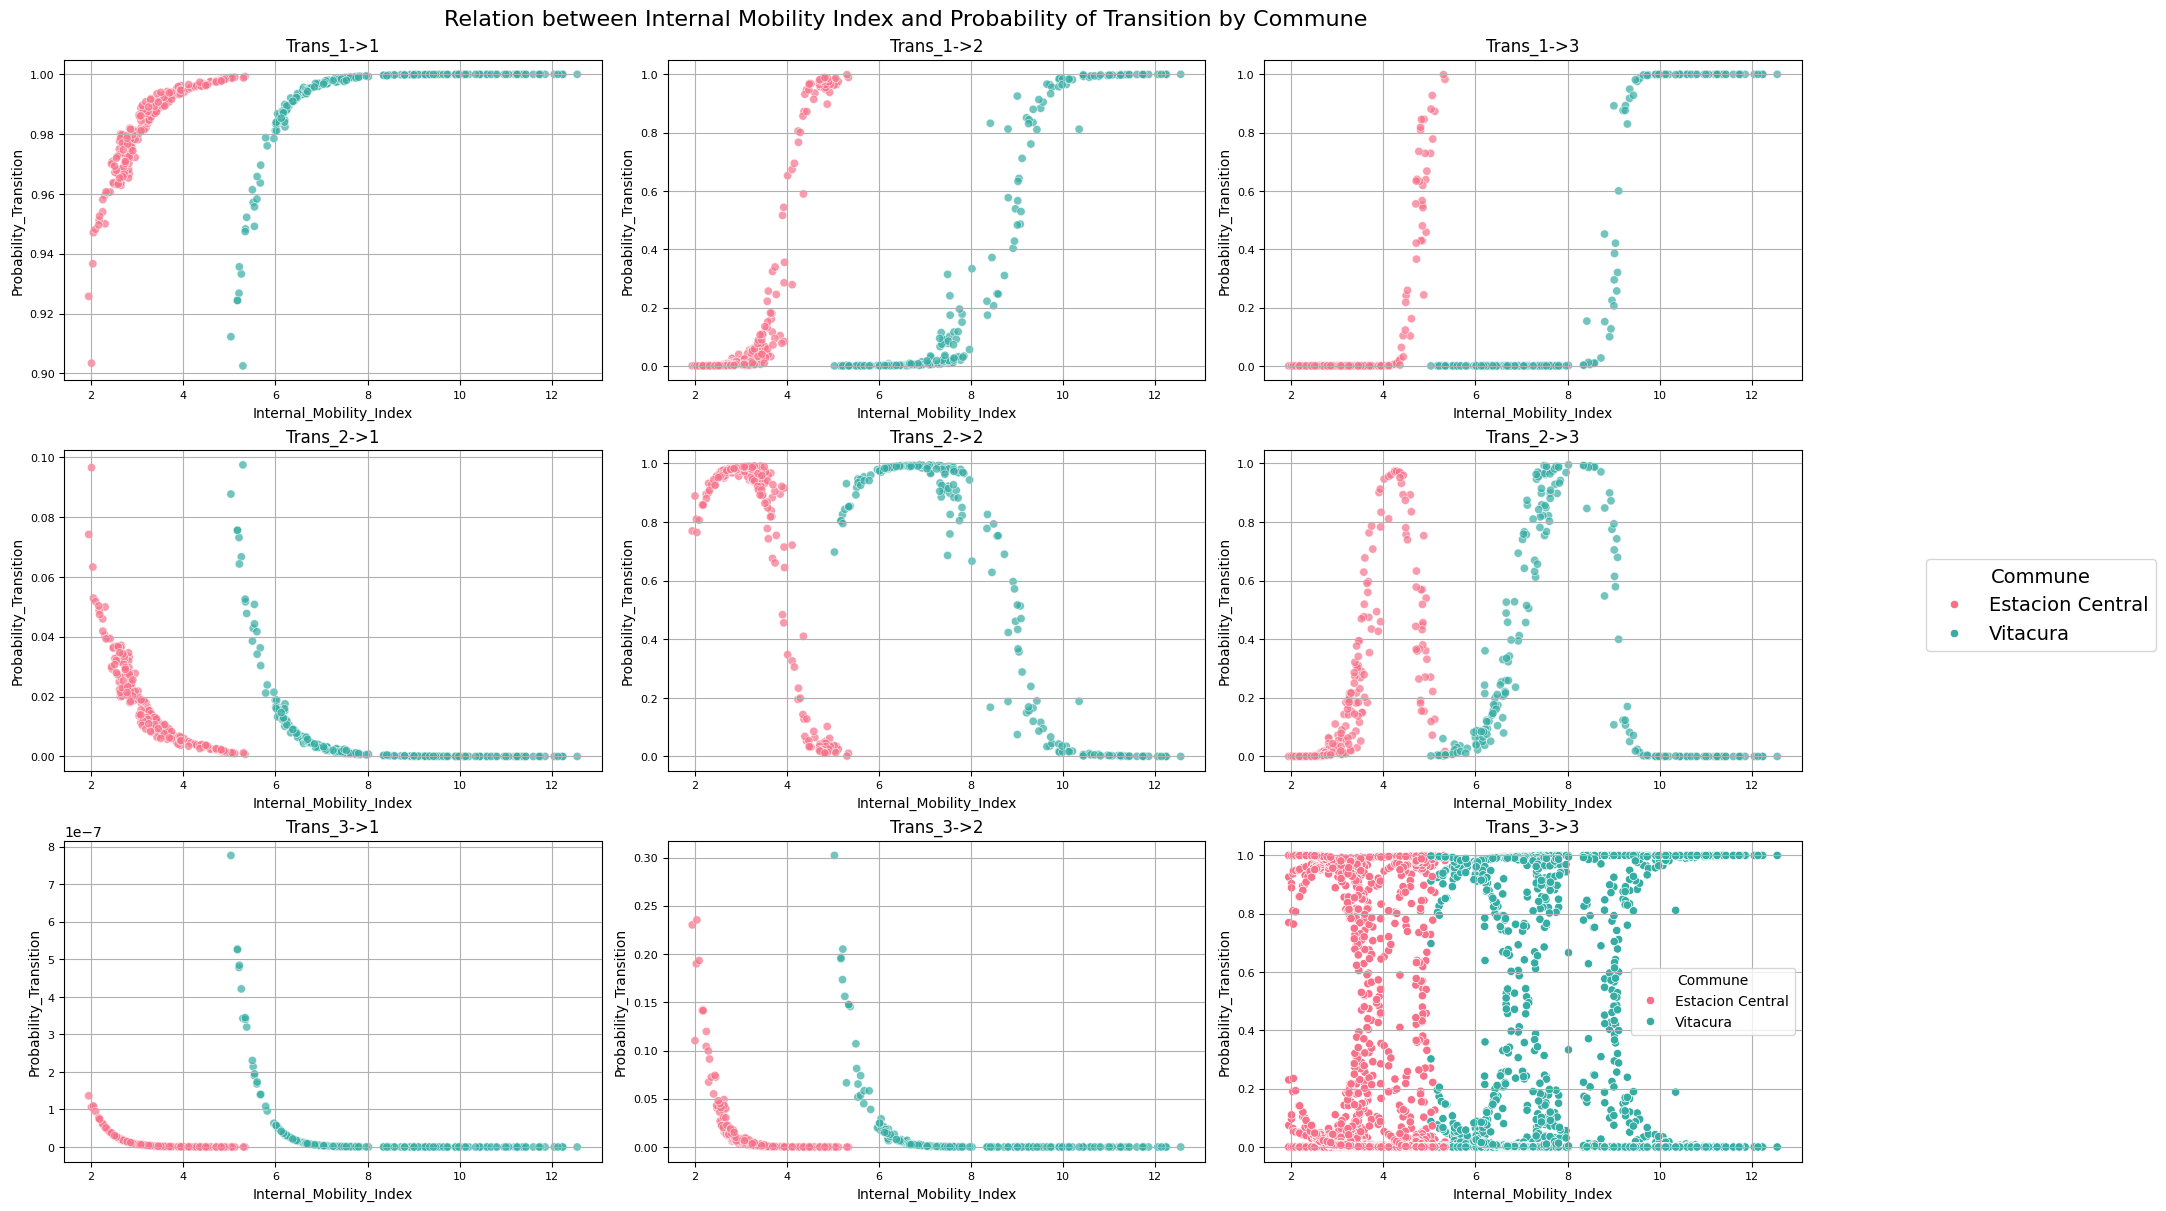

In [ ]:
# Filtrar los datos para las comunas específicas
filtered_communes = lmm_data[(lmm_data['Commune'] == 'Estacion Central') | (lmm_data['Commune'] == 'Vitacura')]

# Lista de transiciones únicas
transiciones_unicas = filtered_communes['Transition'].unique()

# Configurar la figura con subplots
num_transiciones = len(transiciones_unicas)
fig, axes = plt.subplots(
    nrows=(num_transiciones + 2) // 3,  # Filas (3 gráficos por fila)
    ncols=3,  # Columnas
    figsize=(18, 12),
    constrained_layout=True
)

# Aplanar los ejes para iterar fácilmente
axes = axes.flatten()

# Crear un mapa de colores solo para las comunas seleccionadas
palette = sns.color_palette("husl", n_colors=2)

# Crear gráficos separados por transición
for i, transicion in enumerate(transiciones_unicas):
    sns.scatterplot(
        data=filtered_communes[filtered_communes['Transition'] == transicion],
        x='Internal_Mobility_Index',
        y='Probability_Transition',
        hue='Commune',  # Color basado en la comuna
        palette=palette,
        alpha=0.7,
        legend=False,  # Eliminar leyendas de los subplots individuales
        ax=axes[i]
    )
    axes[i].set_title(f'{transicion}', fontsize=12)
    axes[i].set_xlabel('Internal_Mobility_Index', fontsize=10)
    axes[i].set_ylabel('Probability_Transition', fontsize=10)
    axes[i].grid(True)
    axes[i].tick_params(axis='both', labelsize=8)

# Crear una única leyenda para toda la figura
handles, labels = sns.scatterplot(
    data=filtered_communes,
    x='Internal_Mobility_Index',
    y='Probability_Transition',
    hue='Commune',
    palette=palette,
    legend=True
).get_legend_handles_labels()

fig.legend(
    handles, labels, loc='center right', title='Commune',
    fontsize=14, title_fontsize=14, bbox_to_anchor=(1.2, 0.5),
    frameon=True  # Agregar un cuadro a la leyenda
)

# Ajustar el espacio entre gráficos y la leyenda
plt.subplots_adjust(right=1.5)  # Dar más espacio horizontal para la leyenda

# Deshabilitar los subplots vacíos si hay más ejes que gráficos
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Título general
fig.suptitle('Relation between Internal Mobility Index and Probability of Transition by Commune', fontsize=16)
plt.show()


C:\Users\ferna\AppData\Local\Temp\ipykernel_14732\586965439.py:57: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(right=1.5)  # Dar más espacio horizontal para la leyenda


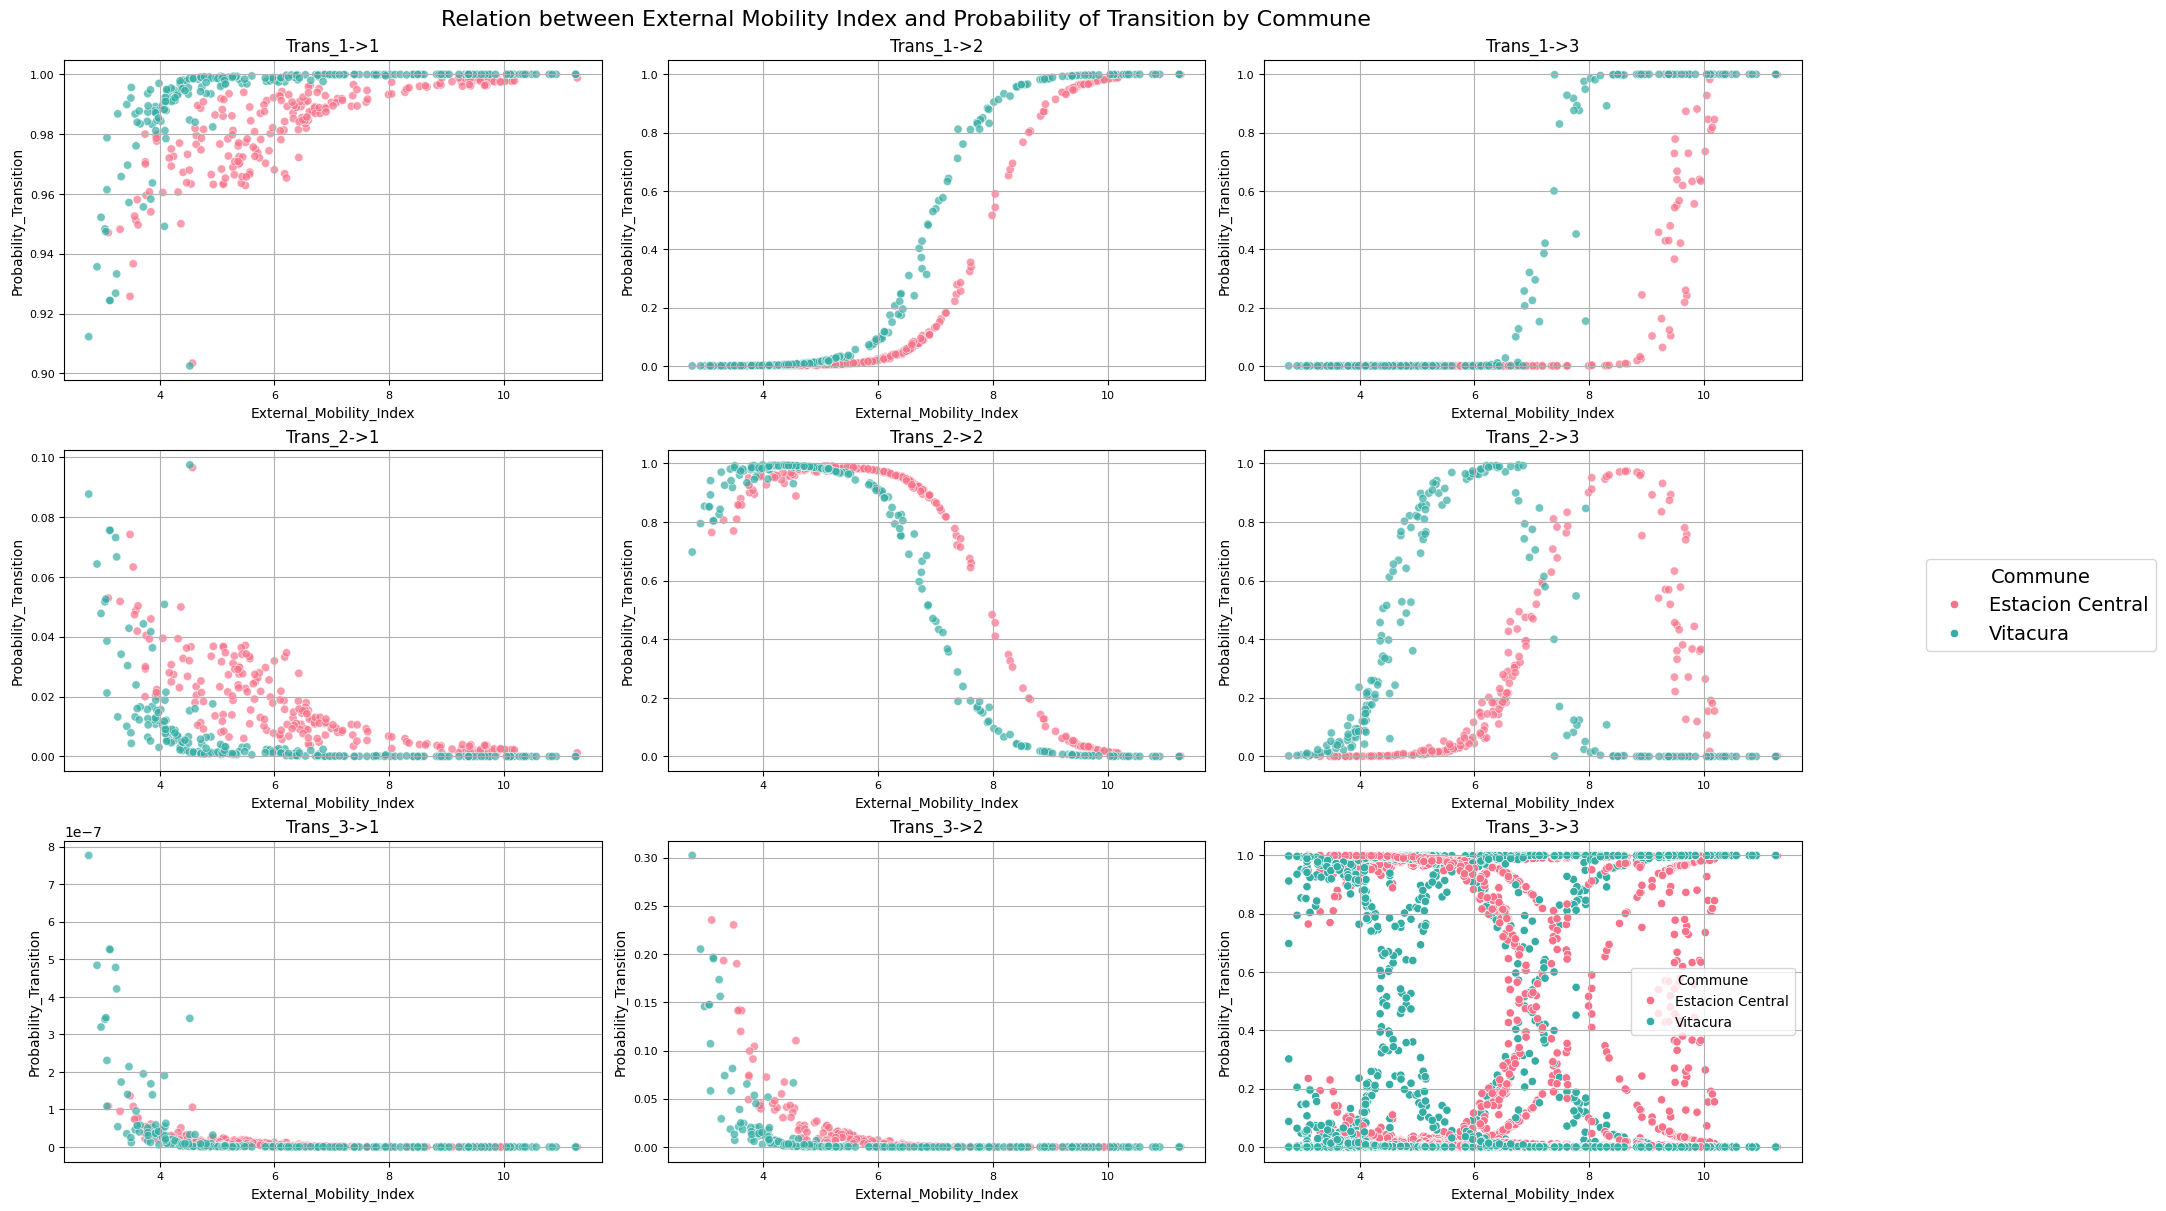

In [ ]:
# Filtrar los datos para las comunas específicas
filtered_communes = lmm_data[(lmm_data['Commune'] == 'Estacion Central') | (lmm_data['Commune'] == 'Vitacura')]

# Lista de transiciones únicas
transiciones_unicas = filtered_communes['Transition'].unique()

# Configurar la figura con subplots
num_transiciones = len(transiciones_unicas)
fig, axes = plt.subplots(
    nrows=(num_transiciones + 2) // 3,  # Filas (3 gráficos por fila)
    ncols=3,  # Columnas
    figsize=(18, 12),
    constrained_layout=True
)

# Aplanar los ejes para iterar fácilmente
axes = axes.flatten()

# Crear un mapa de colores solo para las comunas seleccionadas
palette = sns.color_palette("husl", n_colors=2)

# Crear gráficos separados por transición
for i, transicion in enumerate(transiciones_unicas):
    sns.scatterplot(
        data=filtered_communes[filtered_communes['Transition'] == transicion],
        x='External_Mobility_Index',
        y='Probability_Transition',
        hue='Commune',  # Color basado en la comuna
        palette=palette,
        alpha=0.7,
        legend=False,  # Eliminar leyendas de los subplots individuales
        ax=axes[i]
    )
    axes[i].set_title(f'{transicion}', fontsize=12)
    axes[i].set_xlabel('External_Mobility_Index', fontsize=10)
    axes[i].set_ylabel('Probability_Transition', fontsize=10)
    axes[i].grid(True)
    axes[i].tick_params(axis='both', labelsize=8)

# Crear una única leyenda para toda la figura
handles, labels = sns.scatterplot(
    data=filtered_communes,
    x='External_Mobility_Index',
    y='Probability_Transition',
    hue='Commune',
    palette=palette,
    legend=True
).get_legend_handles_labels()

fig.legend(
    handles, labels, loc='center right', title='Commune',
    fontsize=14, title_fontsize=14, bbox_to_anchor=(1.2, 0.5),
    frameon=True  # Agregar un cuadro a la leyenda
)

# Ajustar el espacio entre gráficos y la leyenda
plt.subplots_adjust(right=1.5)  # Dar más espacio horizontal para la leyenda

# Deshabilitar los subplots vacíos si hay más ejes que gráficos
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Título general
fig.suptitle('Relation between External Mobility Index and Probability of Transition by Commune', fontsize=16)
plt.show()


_______________